# Forcasting  

In this notebook we will predict the closing prices for the next month

In [72]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from copy import deepcopy

In [73]:

# Load the dataset
data = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


In [74]:

# Extract rows for specified companies
companies = ['AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE', 'EURO-CYCLES',
             'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT', 'SOMOCER', 'SOTETEL',
             'SOTUVER', 'TUNISAIR', 'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB']

data_filtered = data[data['companyName'].isin(companies)]


In [75]:
def str_to_datetime(s):
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError:
        return datetime.strptime(s, '%d/%m/%Y')

In [76]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while not last_time:
        # Select the subset of data up to and including the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        # Extract closing prices as features (X) and target (Y)
        values = df_subset['closingPrice'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Attempt to move to the next date within a week
        next_week = dataframe.loc[target_date + timedelta(days=1):target_date + timedelta(days=7)]
        if not next_week.empty:
            next_date = next_week.index[0]
        else:
            print("No more data available for the next week.")
            break

        # Update target_date
        target_date = next_date

        # Check if the process should terminate
        if target_date >= last_date:
            last_time = True

    # Prepare the return DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df


In [77]:

def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)


In [78]:
def train_and_plot_model(data, company_name):
    try:
        print(f"Starting process for {company_name}...")
        n = 3 
        df = data[['date', 'closingPrice']]
        df['date'] = df['date'].apply(str_to_datetime) 
        df.index = df.pop('date')
        
        first_valid_date = df.index[n]
        last_date = df.index[-1]
        windowed_df = df_to_windowed_df(df, first_valid_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), n=n)
        
        if windowed_df is None:
            print("Windowed dataframe is None, exiting...")
            return

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        print("Splitting data into train, validation, and test sets...")
       # Define the split indices
        q_10 = int(len(dates) * 0.1)
        q_20 = int(len(dates) * 0.2)

        # Split the data
        dates_test, X_test, y_test = dates[:q_10], X[:q_10], y[:q_10]
        dates_val, X_val, y_val = dates[q_10:q_20], X[q_10:q_20], y[q_10:q_20]
        dates_train, X_train, y_train = dates[q_20:], X[q_20:], y[q_20:]


        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, y_train, label='Train')
        plt.plot(dates_val, y_val, label='Validation')
        plt.plot(dates_test, y_test, label='Test')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Train, Validation, and Test Data for {company_name}')
        plt.show()

        model = Sequential([layers.Input(shape=(n, 1)),
                            layers.LSTM(64),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)])
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])
        model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

        train_pred = model.predict(X_train).flatten()
        val_pred = model.predict(X_val).flatten()
        test_pred = model.predict(X_test).flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, train_pred)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_pred)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_pred)
        plt.plot(dates_test, y_test)
        plt.legend(['Training Prediction', 'Training Observation',
                    'Validation Prediction', 'Validation Observation',
                    'Test Prediction', 'Test Observation'])
        plt.title(f'Predictions and Observations for {company_name}')
        plt.show()

        # Recursive predictions
        print("Starting recursive predictions...")
        recursive_predictions = []
        recursive_dates = np.concatenate([dates_val, dates_test])

        last_window = deepcopy(X_train[-1])
        for target_date in recursive_dates: 
            next_pred = model.predict(np.array([last_window])).flatten()
            recursive_predictions.append(next_pred)
            last_window = np.roll(last_window, -1)
            last_window[-1] = next_pred
            
        recursive_predictions = np.array(recursive_predictions).flatten()
        plt.figure(figsize=(19, 6))
        plt.plot(dates_train, train_pred)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_pred)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_pred)
        plt.plot(dates_test, y_test)
        plt.plot(recursive_dates, recursive_predictions)
        plt.legend(['Training Predictions', 
                    'Training Observations',
                    'Validation Predictions', 
                    'Validation Observations',
                    'Testing Predictions', 
                    'Testing Observations',
                    'Recursive Predictions'])
        plt.title(f'Recursive Predictions for {company_name}')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


Training and plotting for AMEN BANK
Starting process for AMEN BANK...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


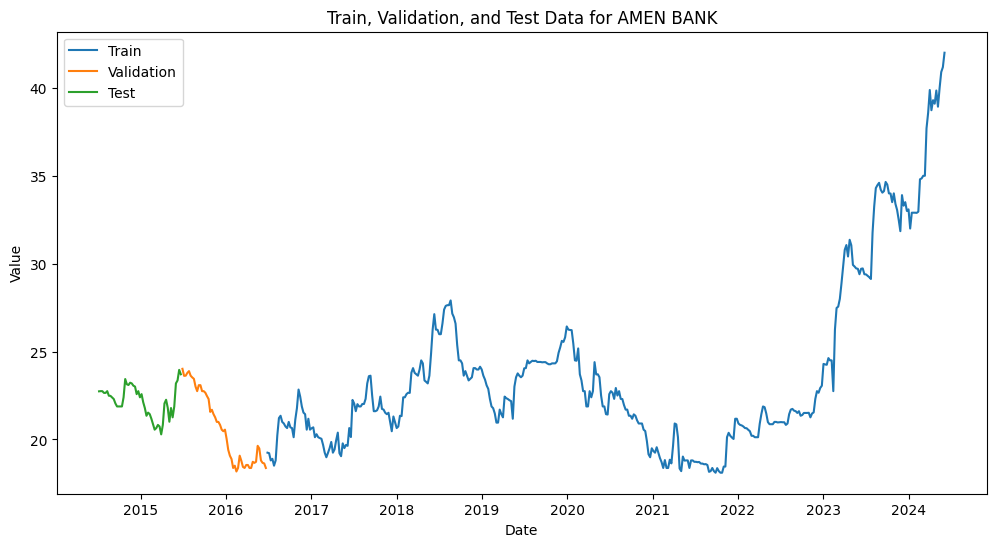

Epoch 1/100
13/13 [==============================] - 1s 19ms/step - loss: 572.5341 - mean_absolute_error: 23.4187 - val_loss: 389.6150 - val_mean_absolute_error: 19.6363
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 499.5388 - mean_absolute_error: 21.7949 - val_loss: 305.1341 - val_mean_absolute_error: 17.3512
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 382.4218 - mean_absolute_error: 18.8827 - val_loss: 186.1879 - val_mean_absolute_error: 13.4862
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 221.8877 - mean_absolute_error: 13.8722 - val_loss: 49.4601 - val_mean_absolute_error: 6.7042
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 68.3776 - mean_absolute_error: 6.1661 - val_loss: 9.0938 - val_mean_absolute_error: 2.5132
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 29.7661 - mean_absolute_error: 4.4596 - val_loss: 34.0416 - val_mean_absolute_error: 5.4

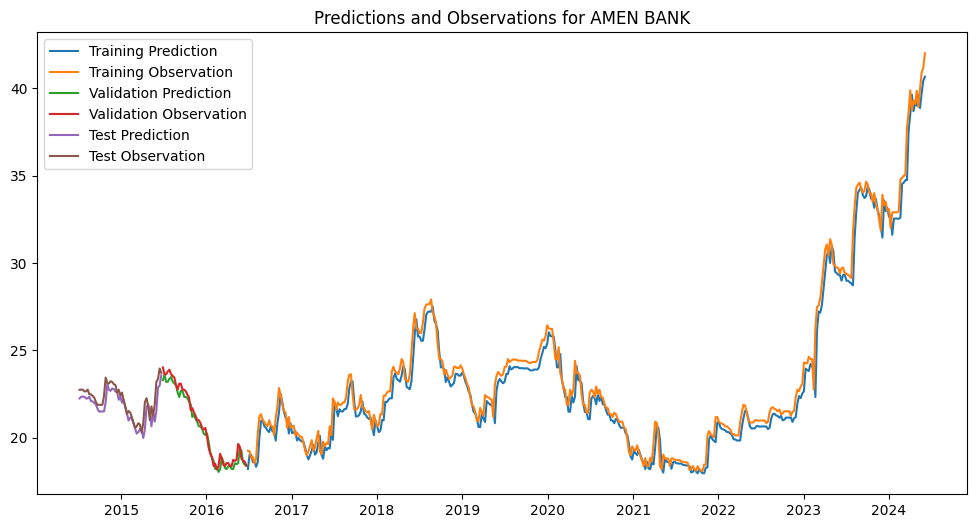

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


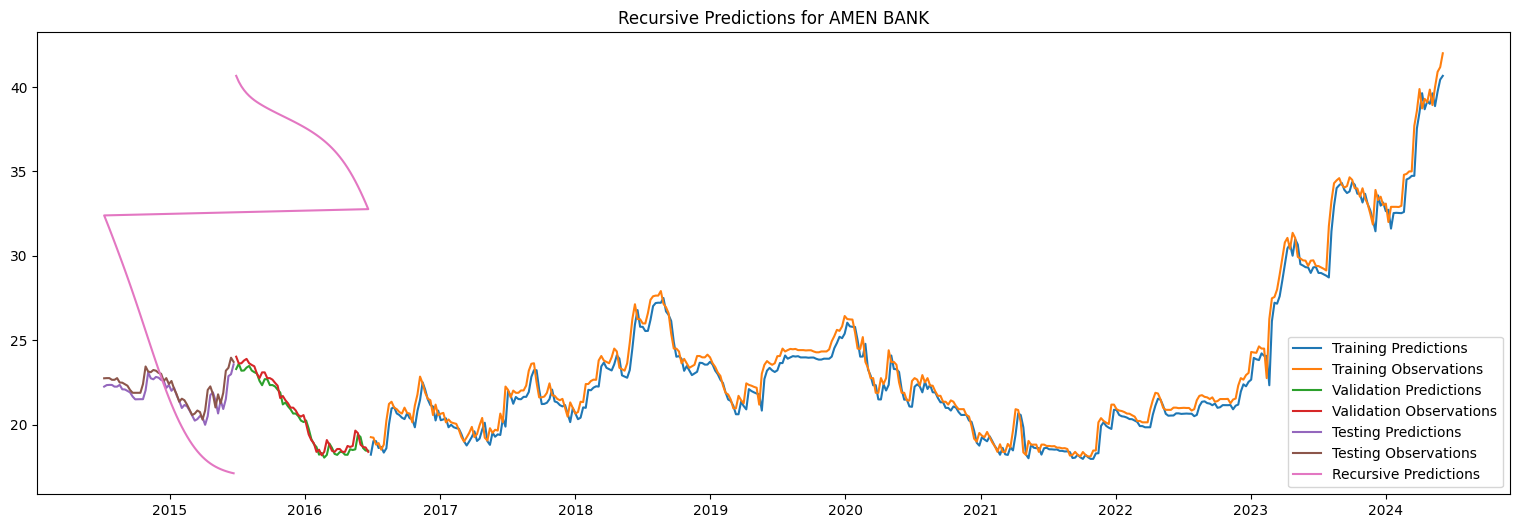

Training and plotting for ARTES
Starting process for ARTES...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


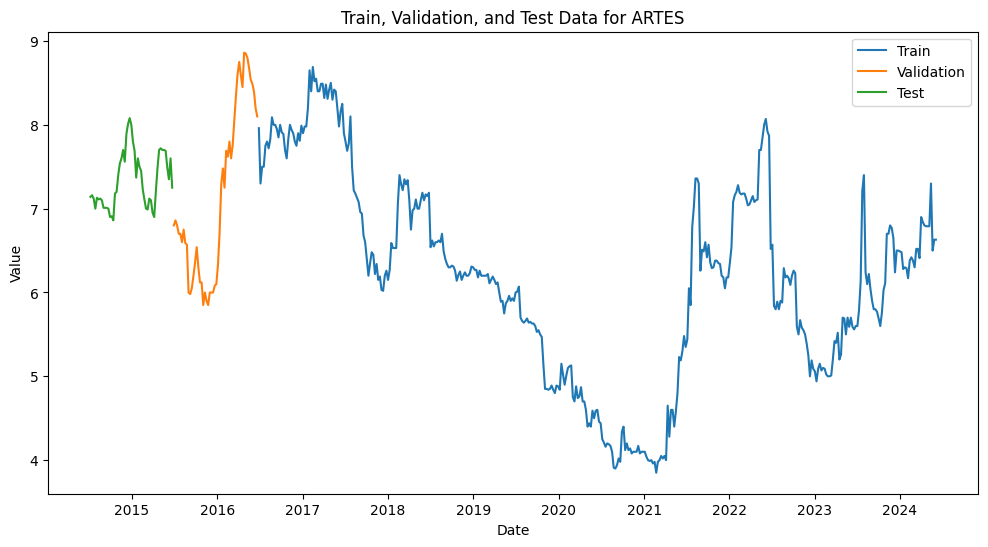

Epoch 1/100
13/13 [==============================] - 1s 19ms/step - loss: 36.7876 - mean_absolute_error: 5.9505 - val_loss: 45.0540 - val_mean_absolute_error: 6.6383
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 30.4952 - mean_absolute_error: 5.4014 - val_loss: 35.0222 - val_mean_absolute_error: 5.8395
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 19.8270 - mean_absolute_error: 4.3082 - val_loss: 18.1852 - val_mean_absolute_error: 4.1658
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 6.0852 - mean_absolute_error: 2.1611 - val_loss: 2.4406 - val_mean_absolute_error: 1.3013
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 1.1789 - mean_absolute_error: 0.9163 - val_loss: 0.7365 - val_mean_absolute_error: 0.7888
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.9156 - mean_absolute_error: 0.8019 - val_loss: 1.5159 - val_mean_absolute_error: 0.9242
Epoch 7/100
13/

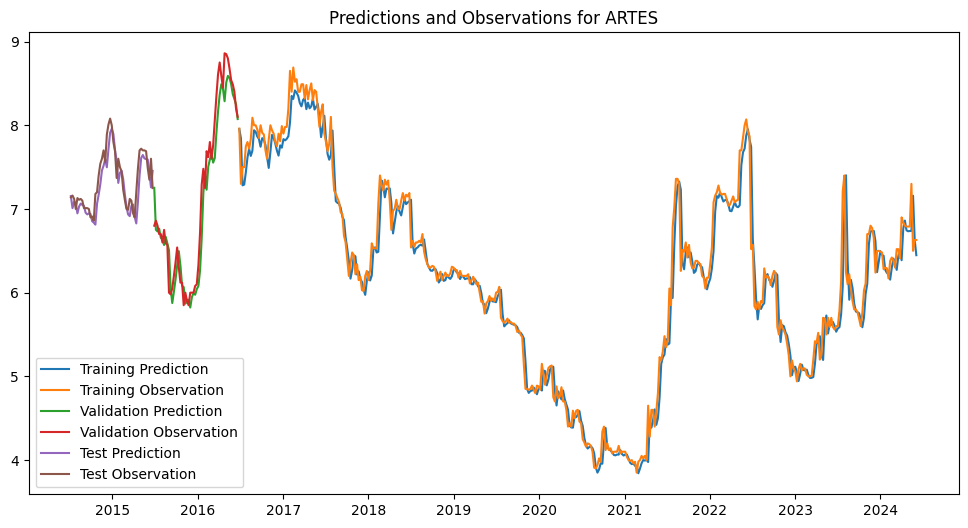

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


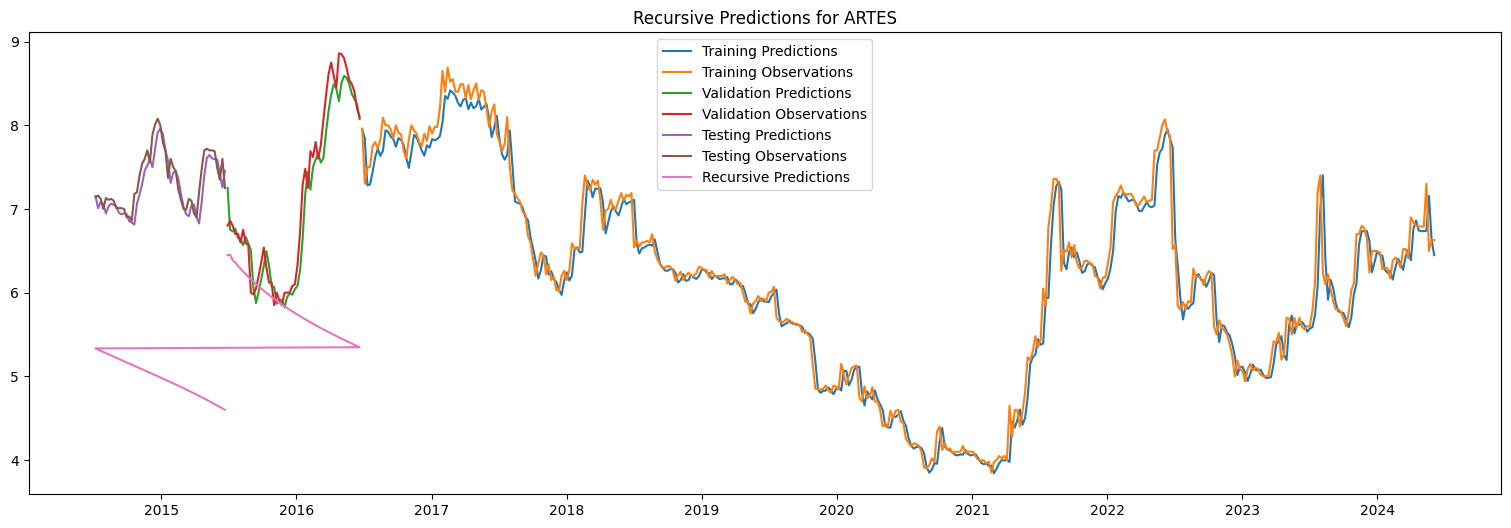

Training and plotting for ASSAD
Starting process for ASSAD...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


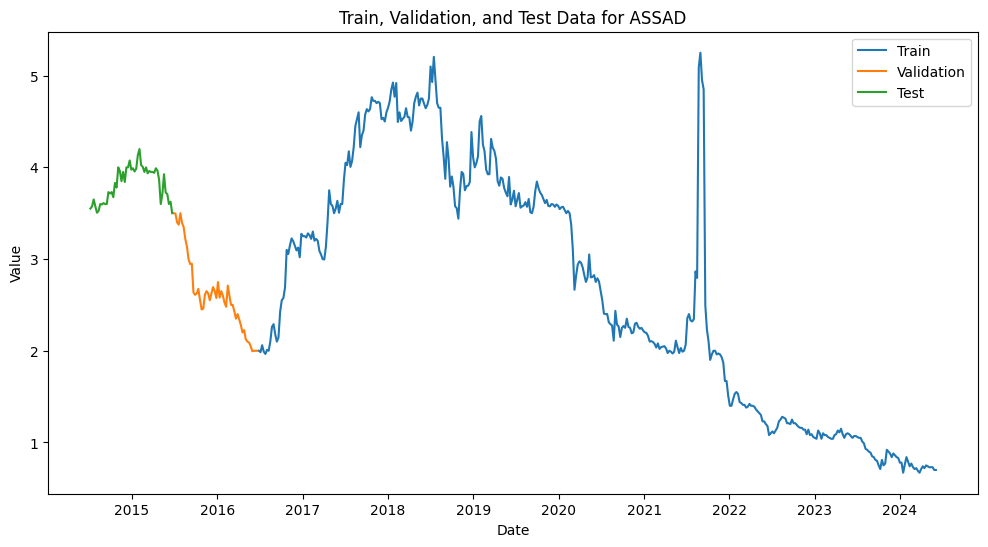

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 7.3161 - mean_absolute_error: 2.4003 - val_loss: 4.7357 - val_mean_absolute_error: 2.1457
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 4.7318 - mean_absolute_error: 1.8907 - val_loss: 1.8790 - val_mean_absolute_error: 1.3425
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 1.2739 - mean_absolute_error: 0.8377 - val_loss: 0.0992 - val_mean_absolute_error: 0.2867
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3336 - mean_absolute_error: 0.4994 - val_loss: 0.2701 - val_mean_absolute_error: 0.5061
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1931 - mean_absolute_error: 0.3407 - val_loss: 0.0327 - val_mean_absolute_error: 0.1588
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1411 - mean_absolute_error: 0.2865 - val_loss: 0.1289 - val_mean_absolute_error: 0.3430
Epoch 7/100
13/13 [==

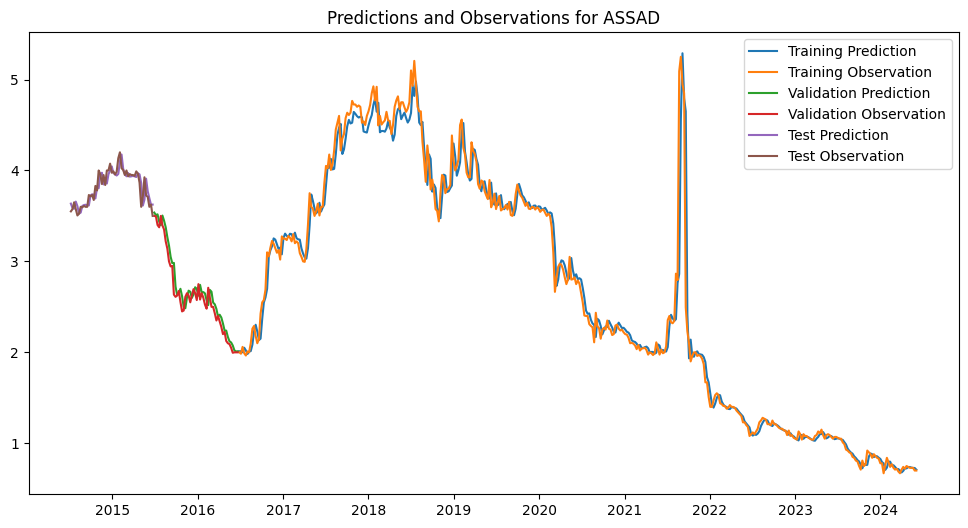

Starting recursive predictions...
1/1 [==============================] - 0s 11ms/step


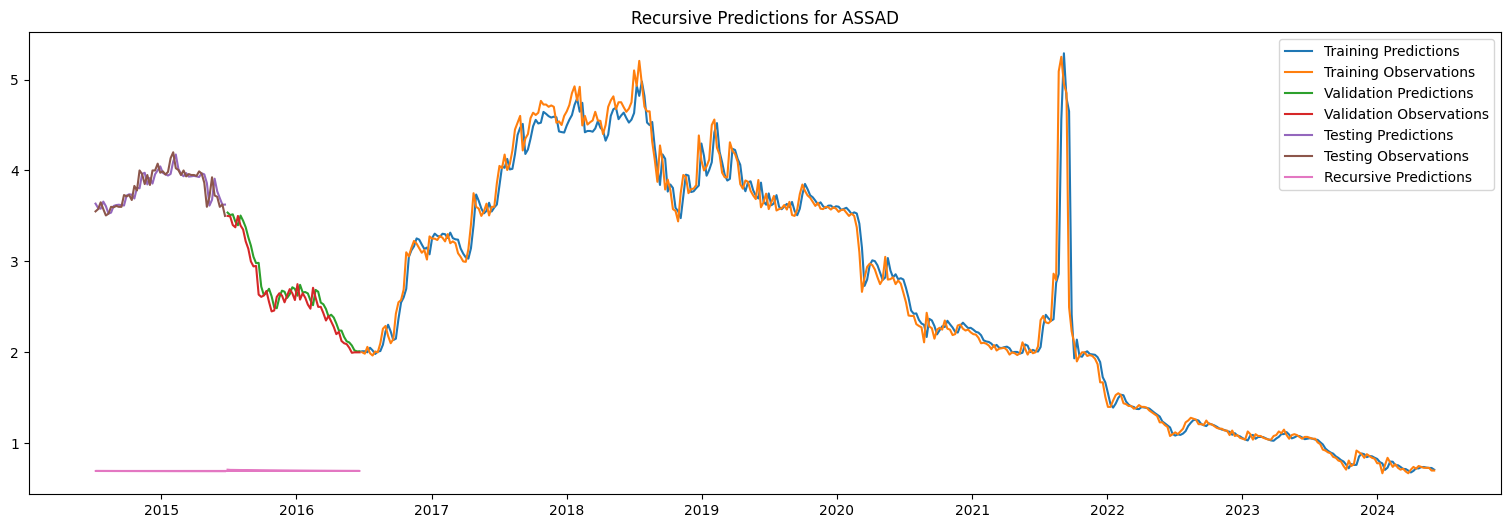

Training and plotting for BIAT
Starting process for BIAT...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


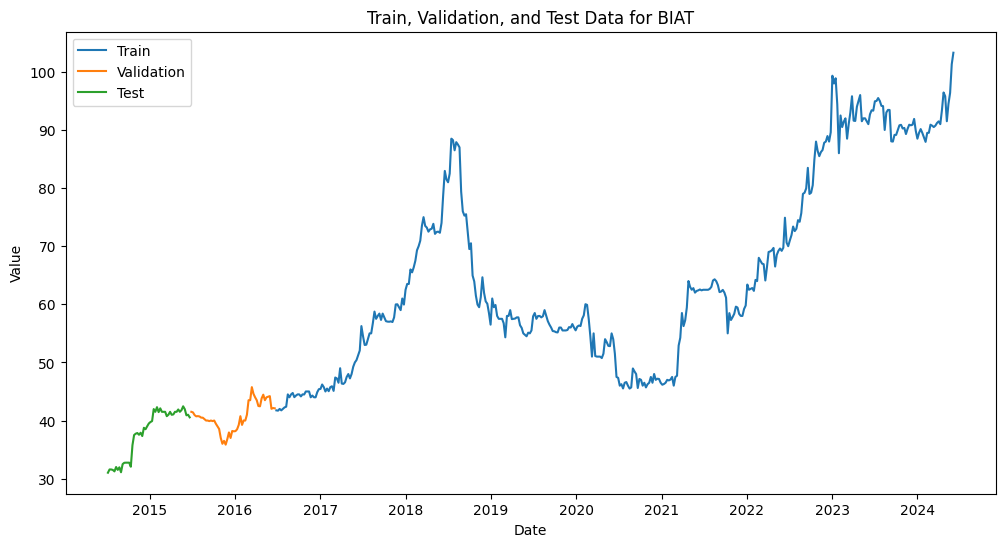

Epoch 1/100
13/13 [==============================] - 1s 19ms/step - loss: 4493.8320 - mean_absolute_error: 64.9713 - val_loss: 1601.7924 - val_mean_absolute_error: 39.9476
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 4370.7378 - mean_absolute_error: 64.0089 - val_loss: 1497.2905 - val_mean_absolute_error: 38.6168
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 4154.5947 - mean_absolute_error: 62.2941 - val_loss: 1300.8995 - val_mean_absolute_error: 35.9814
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 3753.0503 - mean_absolute_error: 58.8831 - val_loss: 933.0569 - val_mean_absolute_error: 30.4370
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 3021.7981 - mean_absolute_error: 52.1495 - val_loss: 415.6547 - val_mean_absolute_error: 20.2134
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 1917.6438 - mean_absolute_error: 39.8191 - val_loss: 19.6891 - val_mean_a

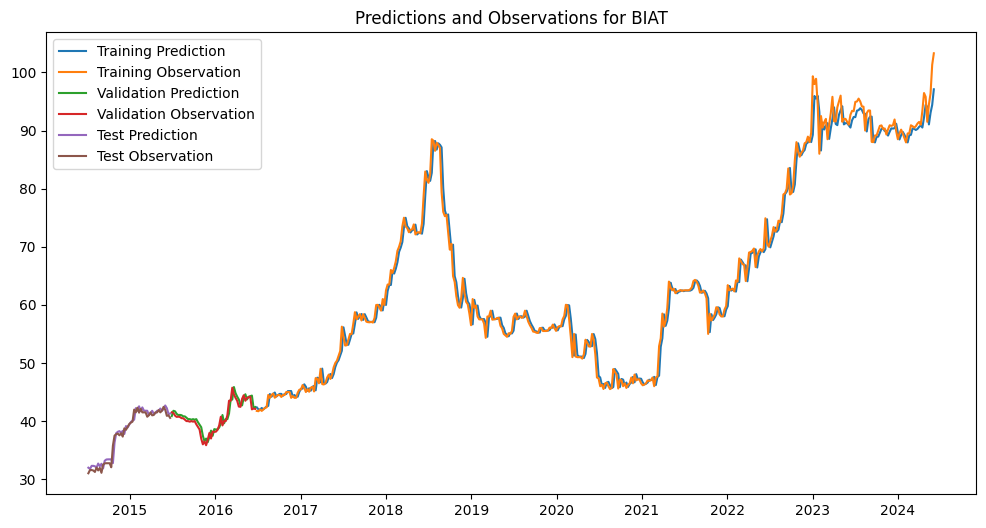

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


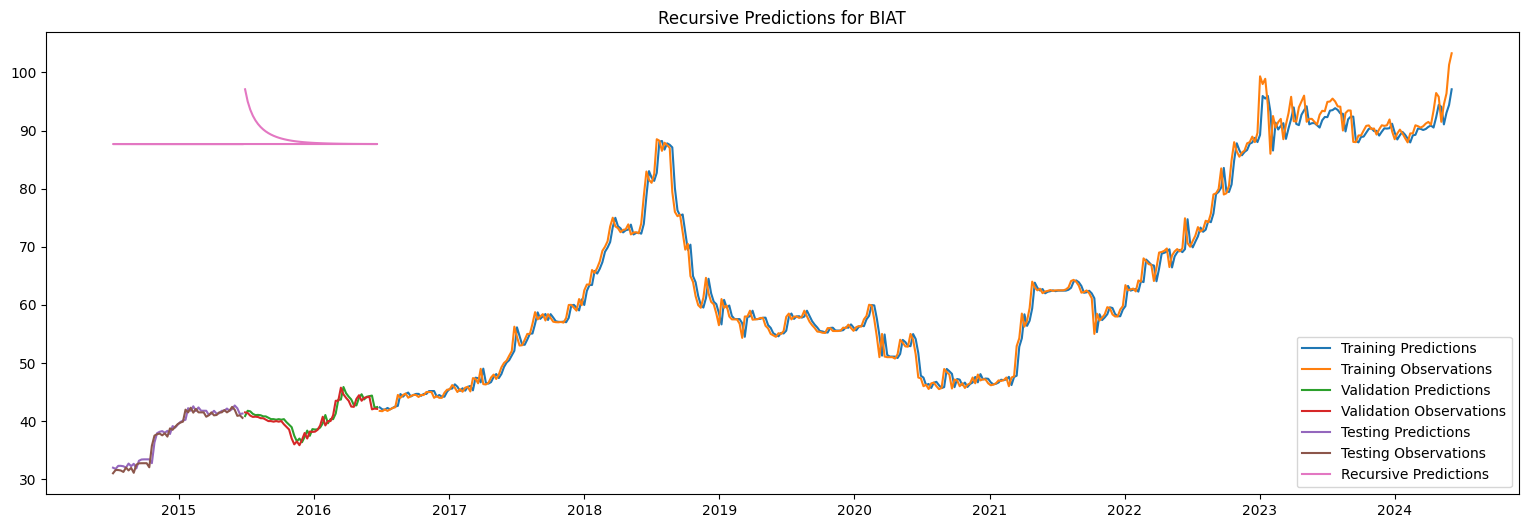

Training and plotting for BANQUE DE TUNISIE
Starting process for BANQUE DE TUNISIE...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


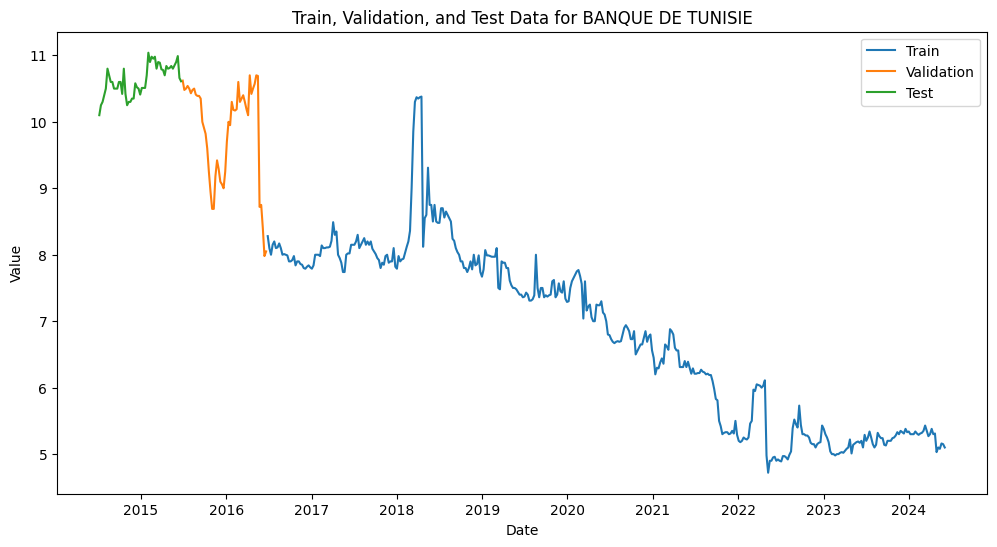

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 48.7115 - mean_absolute_error: 6.8535 - val_loss: 94.6266 - val_mean_absolute_error: 9.6992
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 43.4442 - mean_absolute_error: 6.4671 - val_loss: 84.4648 - val_mean_absolute_error: 9.1609
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 34.3626 - mean_absolute_error: 5.7387 - val_loss: 62.7206 - val_mean_absolute_error: 7.8865
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 18.4144 - mean_absolute_error: 4.1120 - val_loss: 28.9021 - val_mean_absolute_error: 5.3292
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 3.2758 - mean_absolute_error: 1.4602 - val_loss: 3.7933 - val_mean_absolute_error: 1.8194
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 1.5436 - mean_absolute_error: 0.9947 - val_loss: 4.1056 - val_mean_absolute_error: 1.9044
Epoch 7/100
1

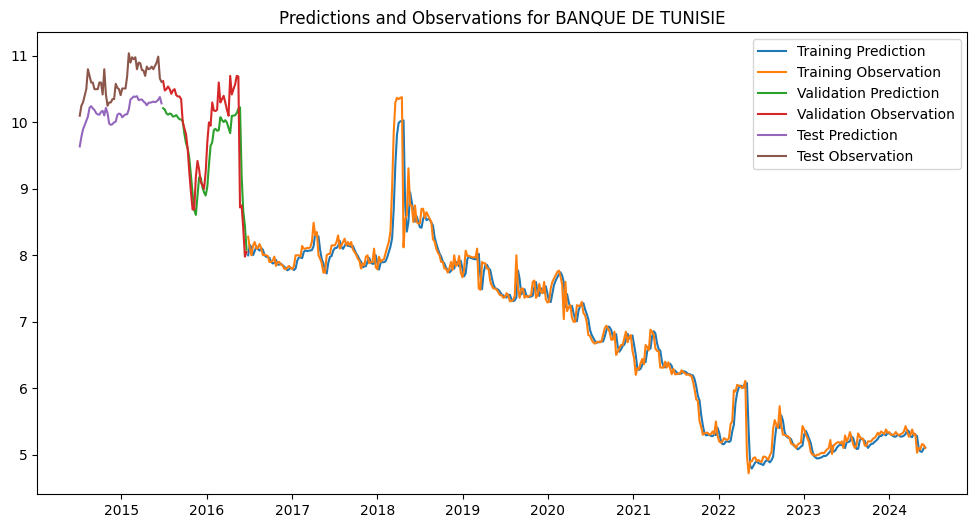

Starting recursive predictions...
1/1 [==============================] - 0s 9ms/step


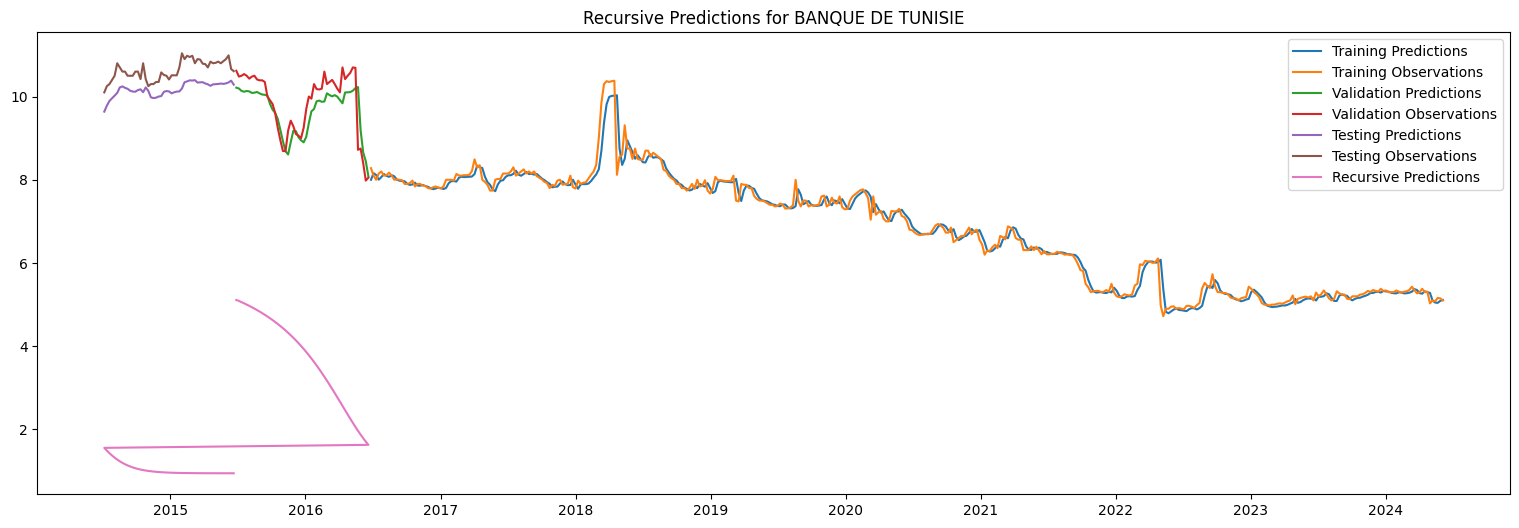

Training and plotting for EURO-CYCLES
Starting process for EURO-CYCLES...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


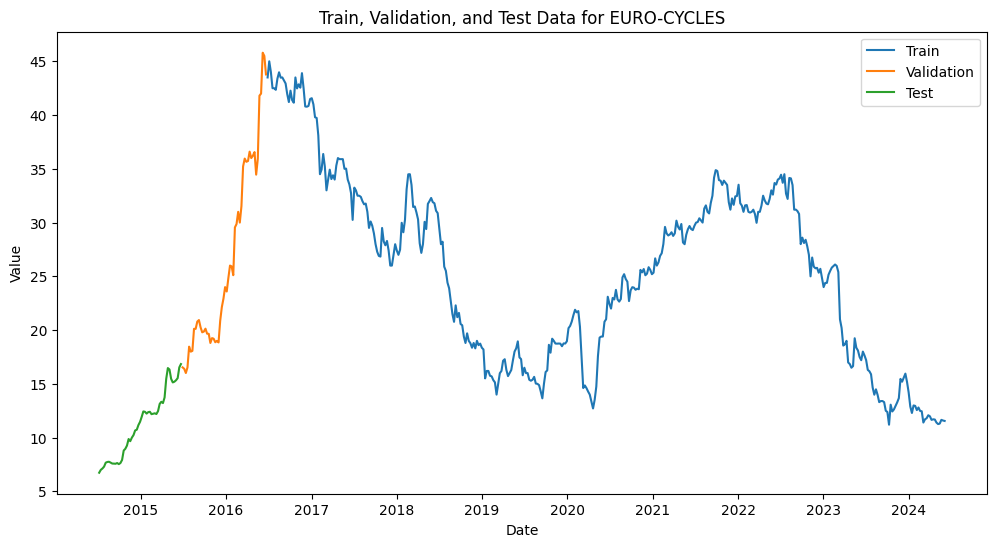

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 689.7519 - mean_absolute_error: 24.8601 - val_loss: 699.7995 - val_mean_absolute_error: 25.0121
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 605.8109 - mean_absolute_error: 23.0626 - val_loss: 604.9243 - val_mean_absolute_error: 22.9903
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 497.3958 - mean_absolute_error: 20.5180 - val_loss: 465.2224 - val_mean_absolute_error: 19.6154
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 342.7449 - mean_absolute_error: 16.1293 - val_loss: 276.0942 - val_mean_absolute_error: 13.8204
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 168.7163 - mean_absolute_error: 10.4627 - val_loss: 110.6023 - val_mean_absolute_error: 7.6767
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 79.0685 - mean_absolute_error: 7.5541 - val_loss: 76.3378 - val_mean_absolute_erro

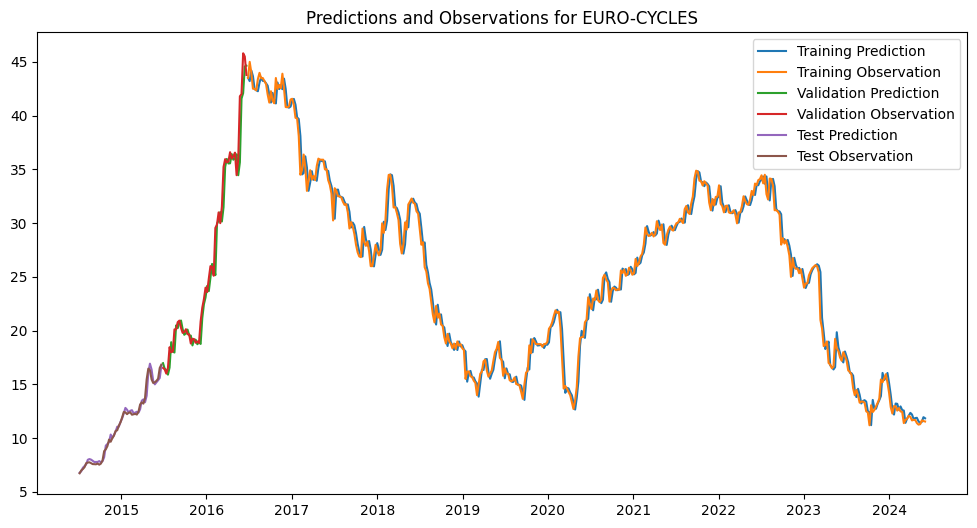

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


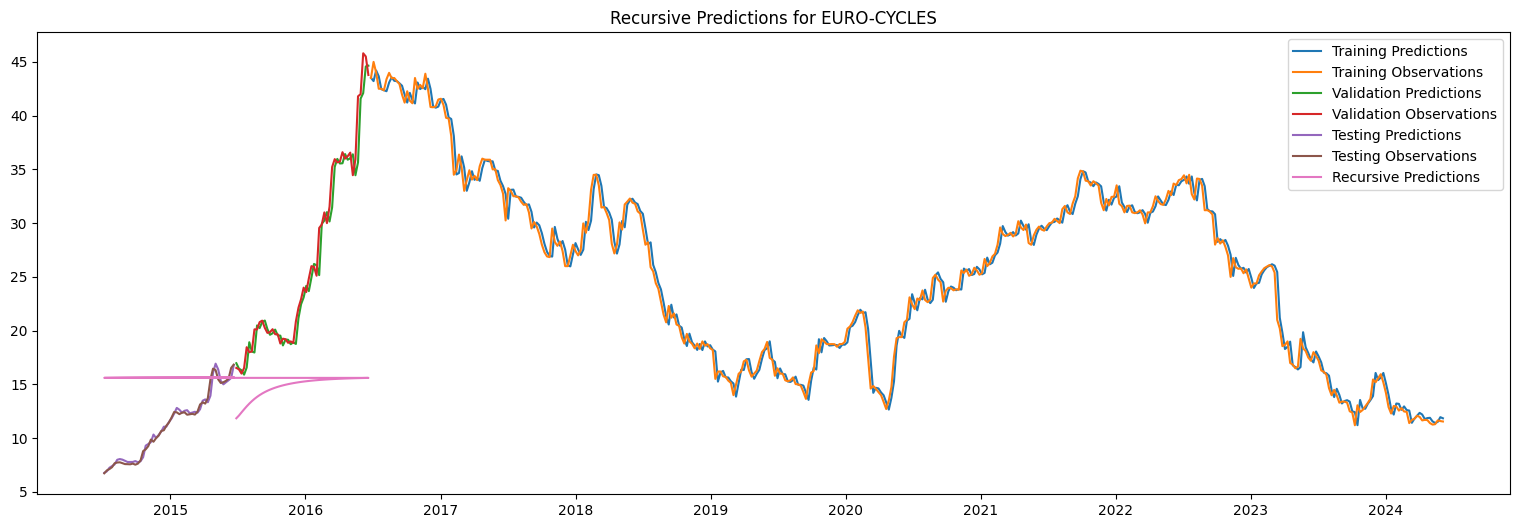

Training and plotting for SOTUMAG
Starting process for SOTUMAG...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


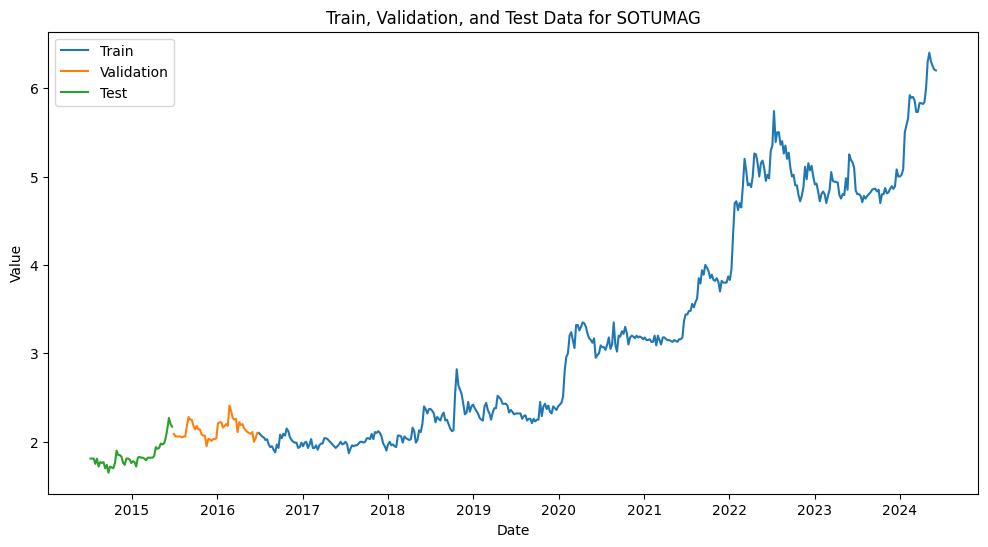

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 10.6863 - mean_absolute_error: 3.0364 - val_loss: 2.7974 - val_mean_absolute_error: 1.6704
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 6.2982 - mean_absolute_error: 2.2877 - val_loss: 0.8095 - val_mean_absolute_error: 0.8966
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 1.4380 - mean_absolute_error: 0.9088 - val_loss: 0.3274 - val_mean_absolute_error: 0.5668
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4667 - mean_absolute_error: 0.6230 - val_loss: 0.3591 - val_mean_absolute_error: 0.5939
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.2057 - mean_absolute_error: 0.3585 - val_loss: 0.0365 - val_mean_absolute_error: 0.1784
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1552 - mean_absolute_error: 0.3148 - val_loss: 0.1305 - val_mean_absolute_error: 0.3527
Epoch 7/100
13/13 [=

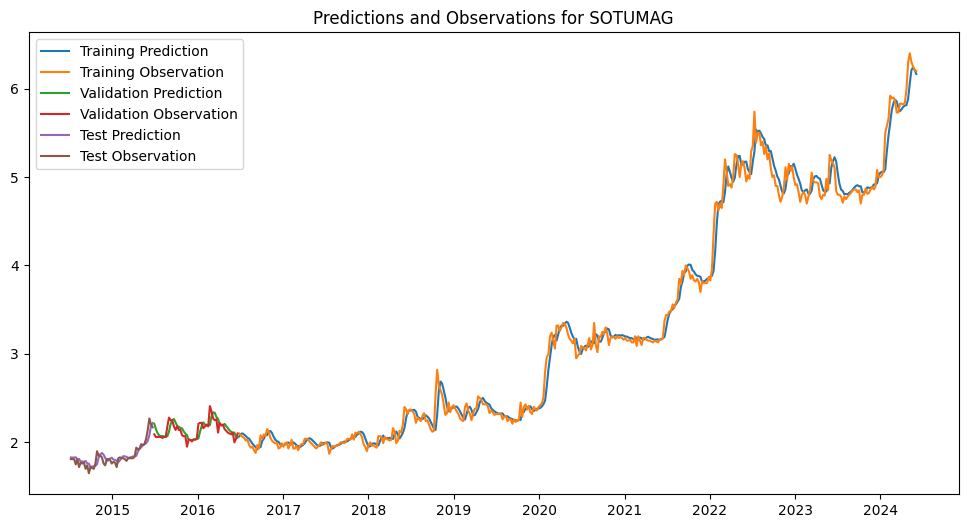

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


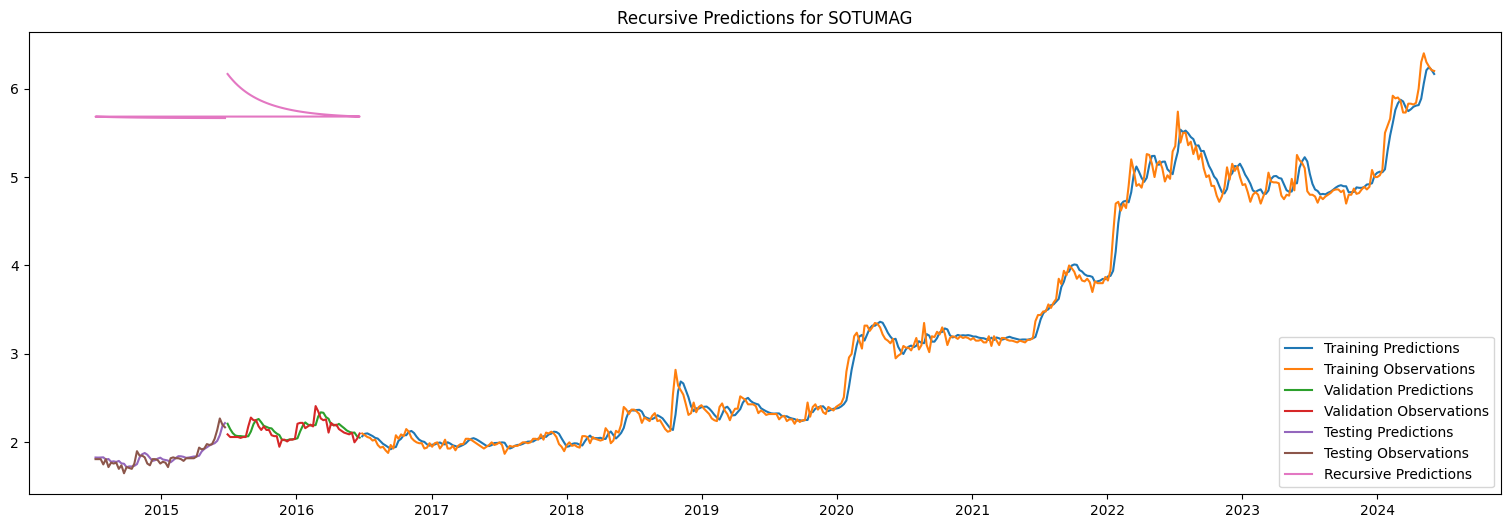

Training and plotting for ONE TECH
Starting process for ONE TECH...
No more data available for the next week.
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


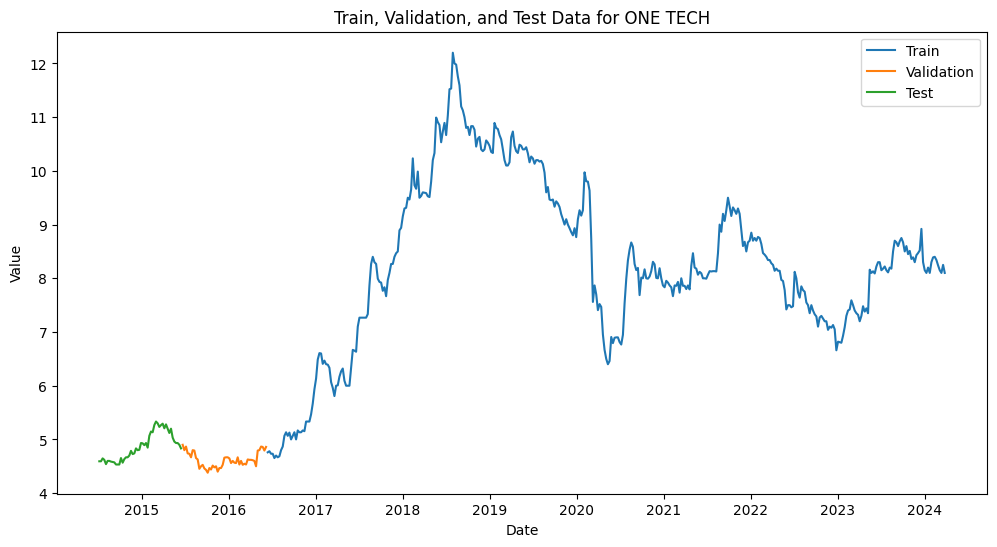

Epoch 1/100
13/13 [==============================] - 1s 17ms/step - loss: 69.5986 - mean_absolute_error: 8.1940 - val_loss: 18.4564 - val_mean_absolute_error: 4.2940
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 58.0171 - mean_absolute_error: 7.4631 - val_loss: 12.4079 - val_mean_absolute_error: 3.5203
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 39.4014 - mean_absolute_error: 6.0773 - val_loss: 3.4274 - val_mean_absolute_error: 1.8481
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 14.4163 - mean_absolute_error: 3.4253 - val_loss: 1.5506 - val_mean_absolute_error: 1.2415
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 2.1577 - mean_absolute_error: 1.2048 - val_loss: 12.5703 - val_mean_absolute_error: 3.5442
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 2.2958 - mean_absolute_error: 1.2882 - val_loss: 6.8492 - val_mean_absolute_error: 2.6154
Epoch 7/100
13

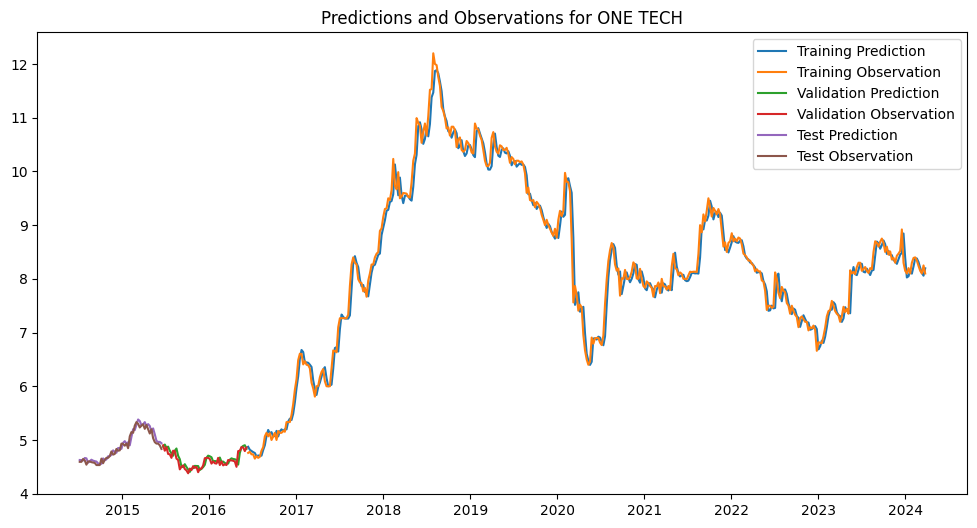

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


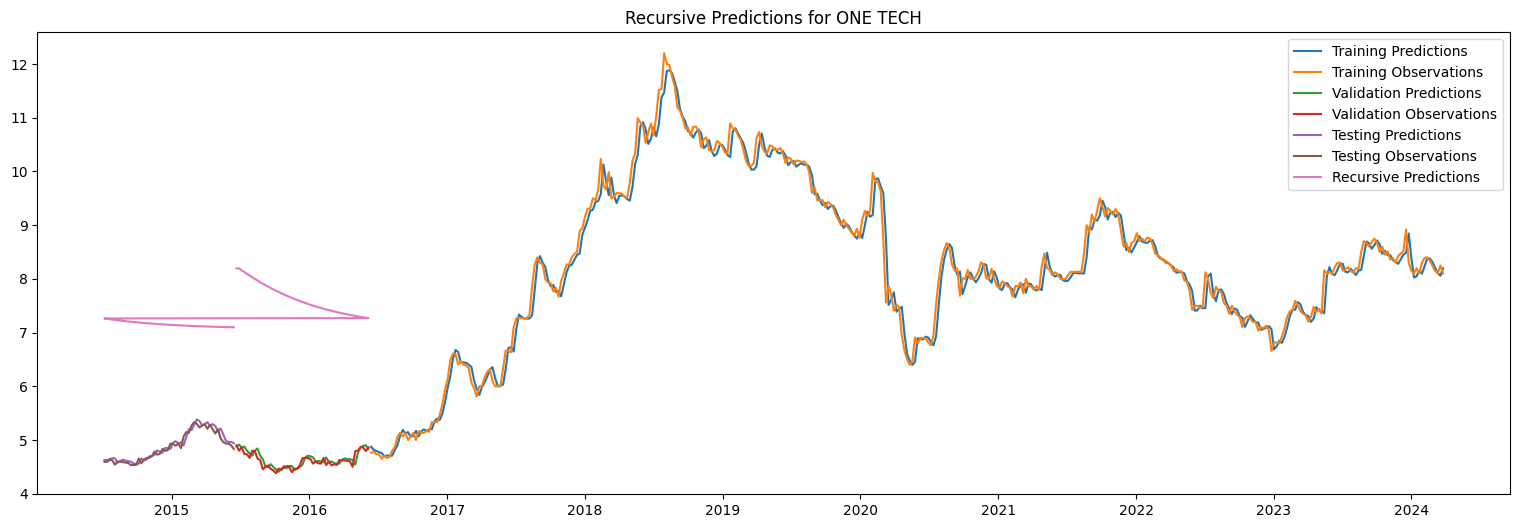

Training and plotting for SAH
Starting process for SAH...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


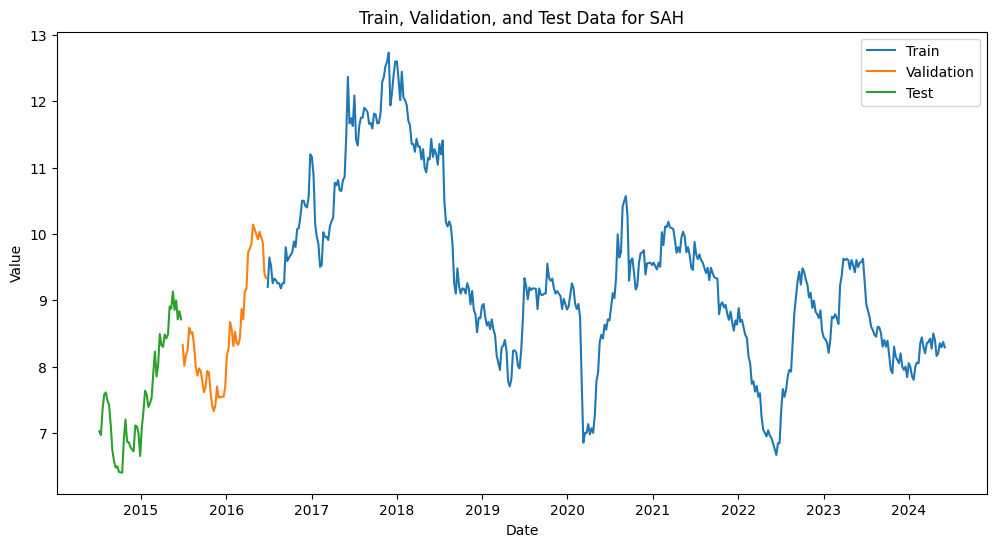

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 78.0730 - mean_absolute_error: 8.7355 - val_loss: 54.4582 - val_mean_absolute_error: 7.3339
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 58.3922 - mean_absolute_error: 7.5271 - val_loss: 34.3425 - val_mean_absolute_error: 5.8055
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 30.8386 - mean_absolute_error: 5.3571 - val_loss: 8.0790 - val_mean_absolute_error: 2.7342
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 5.3457 - mean_absolute_error: 1.8457 - val_loss: 2.5505 - val_mean_absolute_error: 1.4132
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 2.6139 - mean_absolute_error: 1.4361 - val_loss: 2.7519 - val_mean_absolute_error: 1.4824
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 1.5173 - mean_absolute_error: 0.9592 - val_loss: 0.6807 - val_mean_absolute_error: 0.7459
Epoch 7/100
13/1

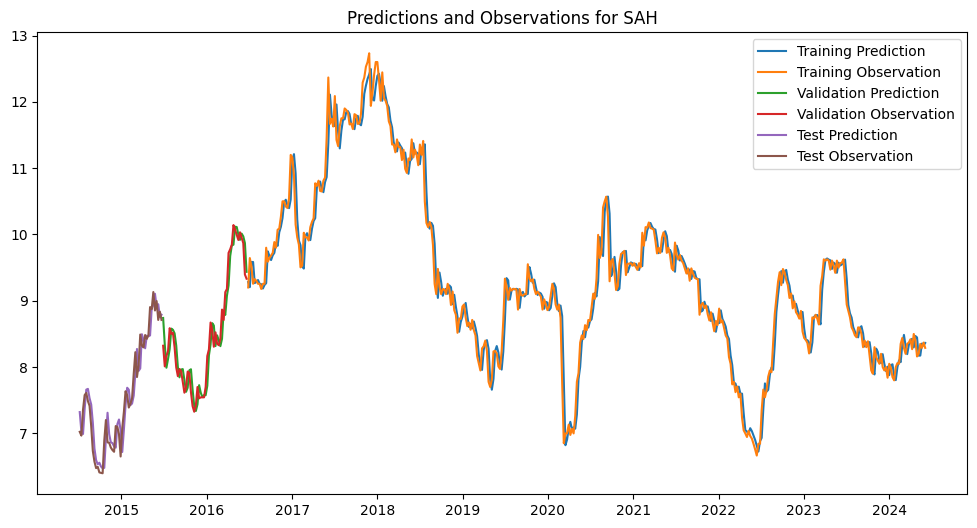

Starting recursive predictions...
1/1 [==============================] - 0s 9ms/step


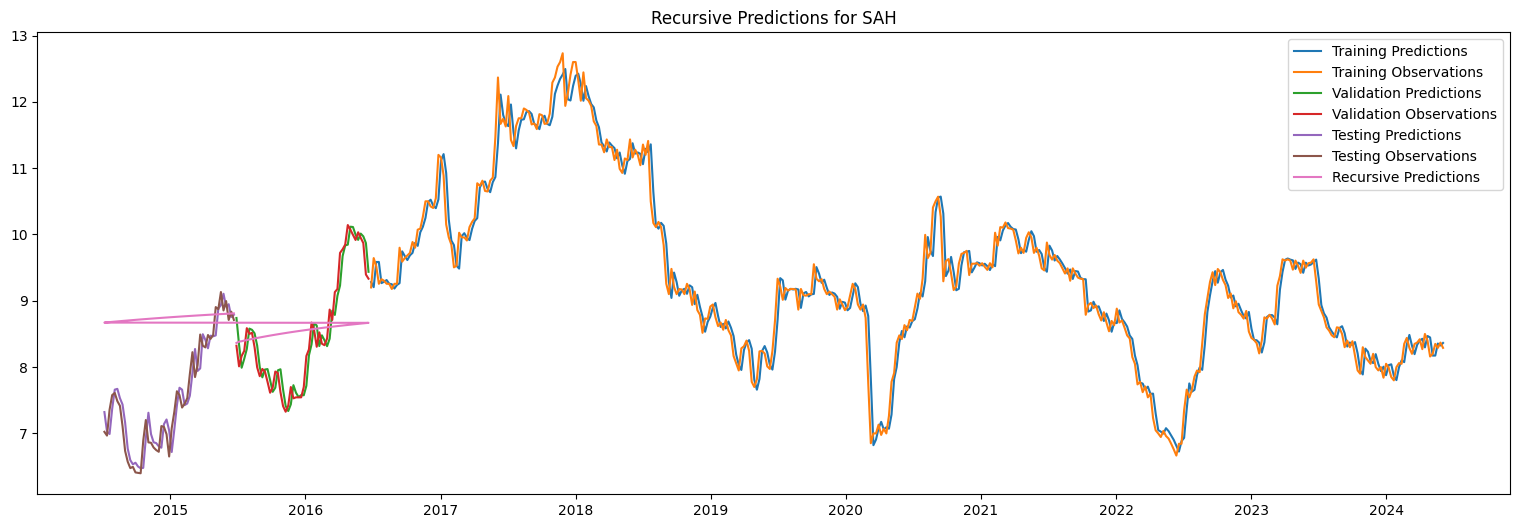

Training and plotting for SFBT
Starting process for SFBT...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


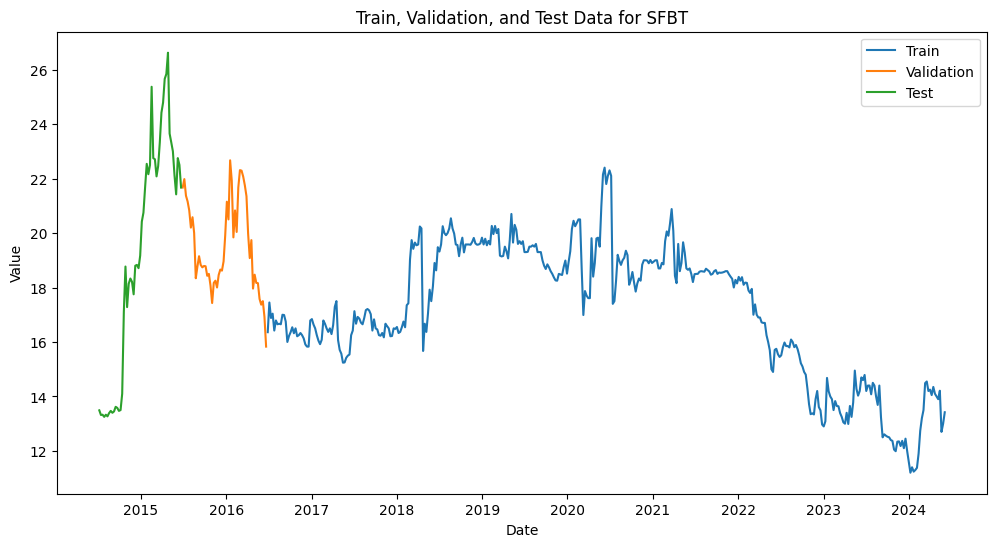

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 240.0370 - mean_absolute_error: 15.2861 - val_loss: 266.8356 - val_mean_absolute_error: 16.2545
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 157.0694 - mean_absolute_error: 12.2565 - val_loss: 156.7212 - val_mean_absolute_error: 12.4083
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 63.7399 - mean_absolute_error: 7.3595 - val_loss: 43.1749 - val_mean_absolute_error: 6.3384
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 10.1989 - mean_absolute_error: 2.6423 - val_loss: 3.5386 - val_mean_absolute_error: 1.5078
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 8.5876 - mean_absolute_error: 2.2696 - val_loss: 8.0490 - val_mean_absolute_error: 2.3388
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 5.9356 - mean_absolute_error: 2.0585 - val_loss: 11.4055 - val_mean_absolute_error: 2.9593
Epoch

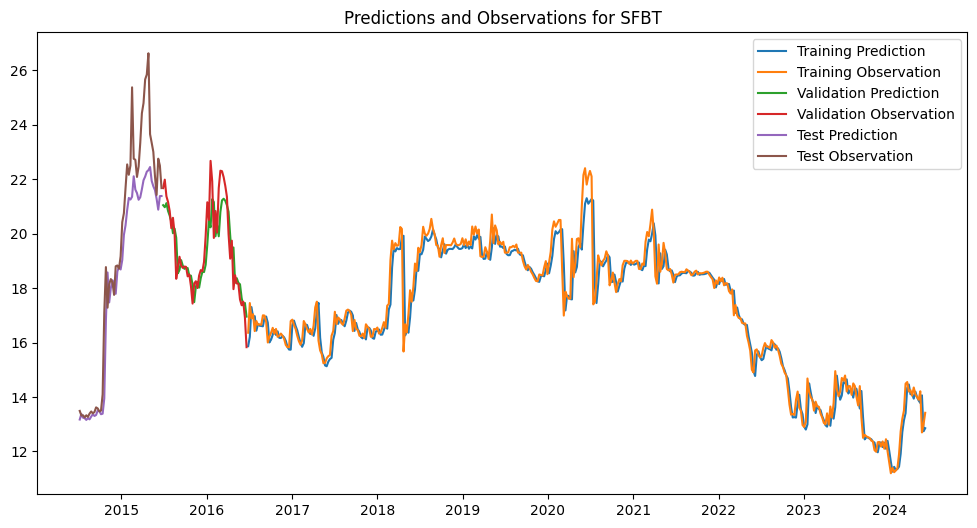

Starting recursive predictions...
1/1 [==============================] - 0s 11ms/step


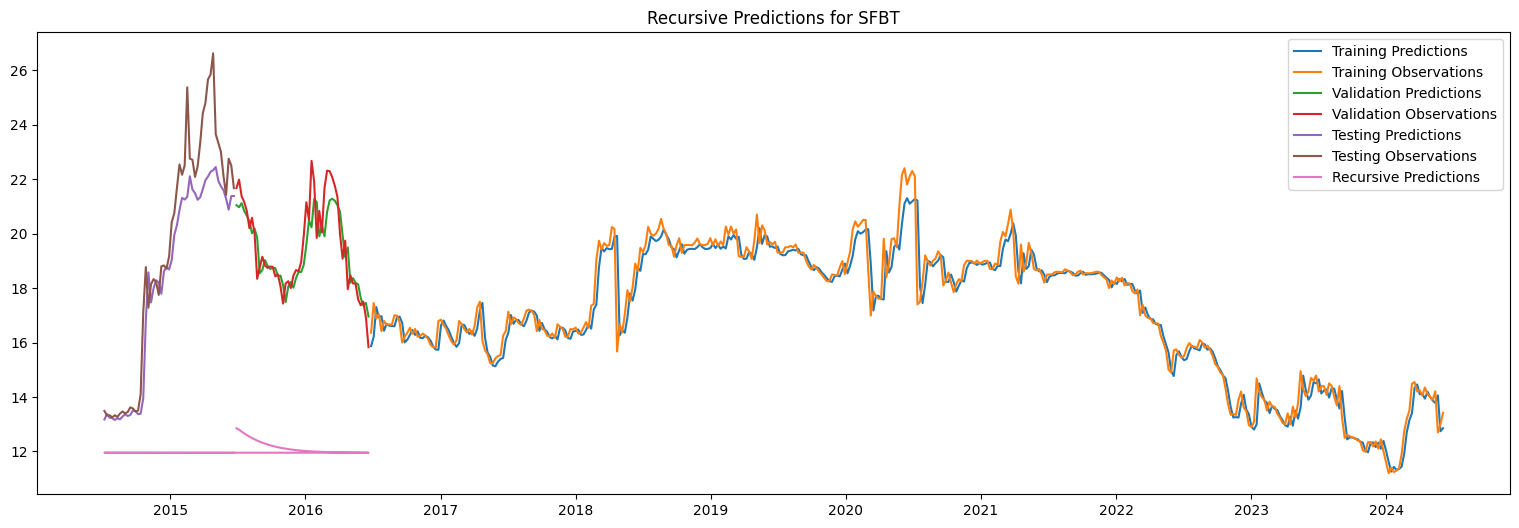

Training and plotting for SOMOCER
Starting process for SOMOCER...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


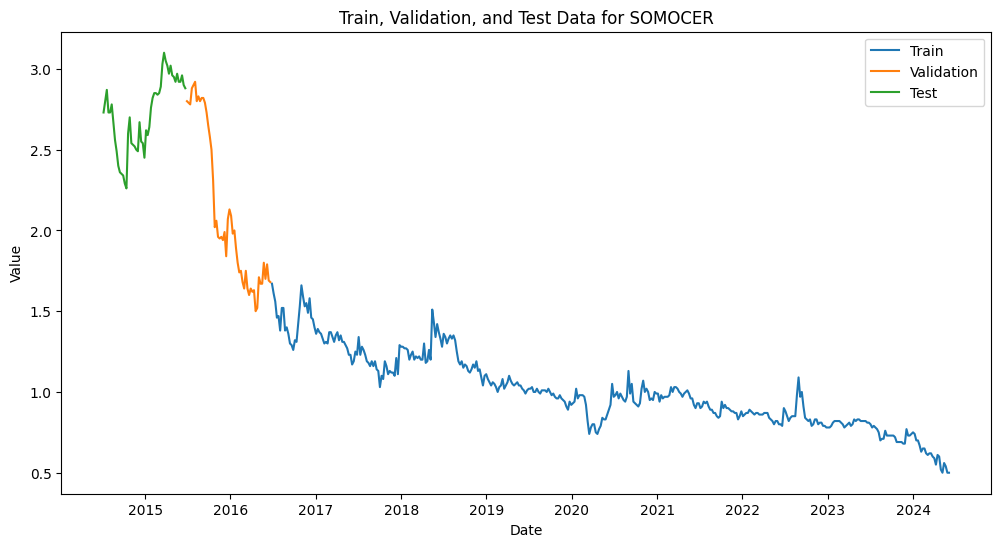

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 1.0152 - mean_absolute_error: 0.9807 - val_loss: 4.1269 - val_mean_absolute_error: 1.9800
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.8062 - mean_absolute_error: 0.8709 - val_loss: 3.2980 - val_mean_absolute_error: 1.7660
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5073 - mean_absolute_error: 0.6815 - val_loss: 1.7212 - val_mean_absolute_error: 1.2654
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1091 - mean_absolute_error: 0.2660 - val_loss: 0.1014 - val_mean_absolute_error: 0.2422
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0284 - mean_absolute_error: 0.1548 - val_loss: 0.1315 - val_mean_absolute_error: 0.2893
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0724 - val_loss: 0.2815 - val_mean_absolute_error: 0.4733
Epoch 7/100
13/13 [==

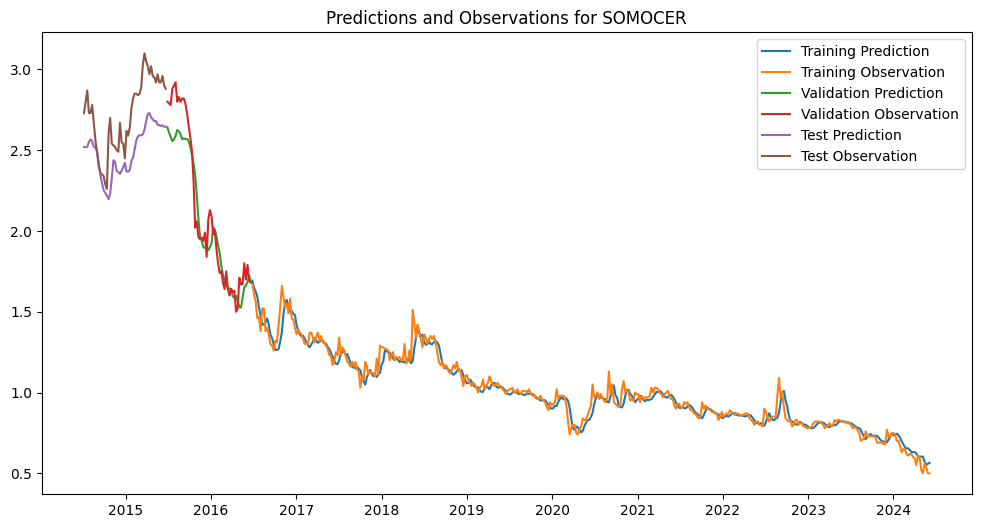

Starting recursive predictions...
1/1 [==============================] - 0s 11ms/step


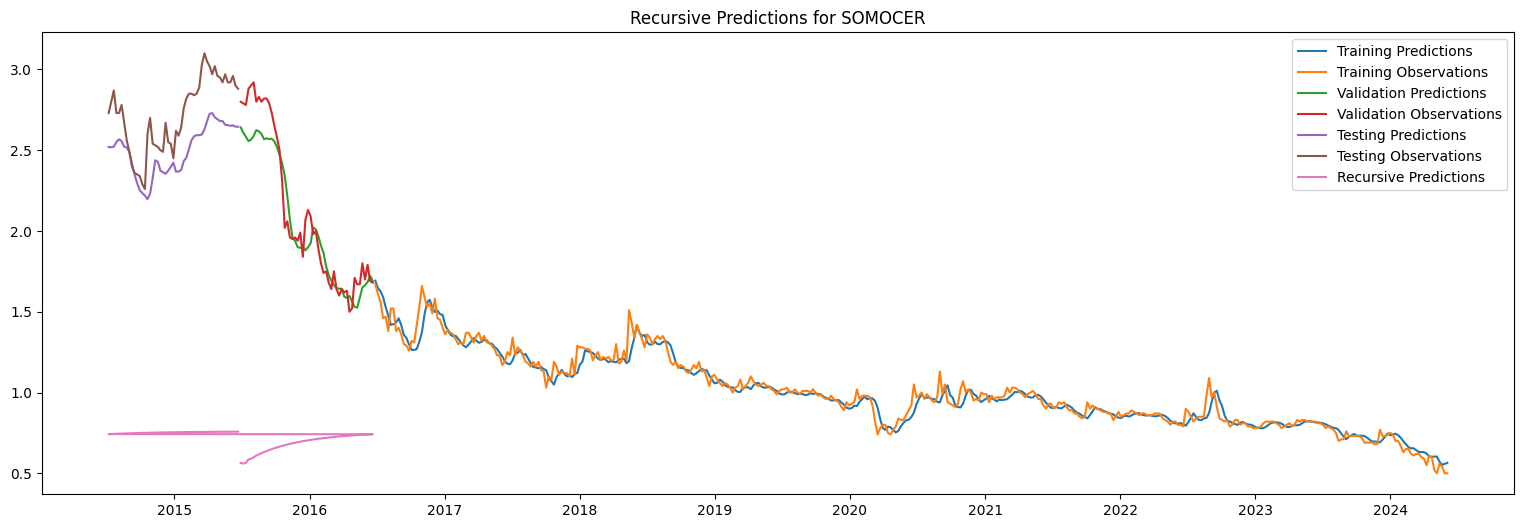

Training and plotting for SOTETEL
Starting process for SOTETEL...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


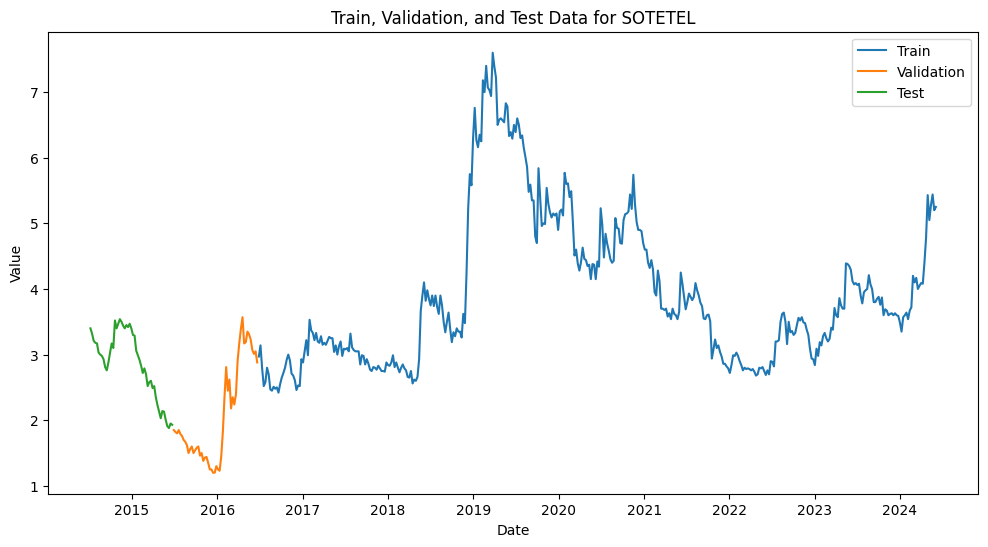

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 13.3195 - mean_absolute_error: 3.4824 - val_loss: 2.7037 - val_mean_absolute_error: 1.5289
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 6.6984 - mean_absolute_error: 2.3868 - val_loss: 0.3875 - val_mean_absolute_error: 0.4923
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.9301 - mean_absolute_error: 0.7811 - val_loss: 0.9574 - val_mean_absolute_error: 0.9317
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6044 - mean_absolute_error: 0.6802 - val_loss: 0.1635 - val_mean_absolute_error: 0.3851
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3699 - mean_absolute_error: 0.3809 - val_loss: 0.1451 - val_mean_absolute_error: 0.3613
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.2666 - mean_absolute_error: 0.4257 - val_loss: 0.2133 - val_mean_absolute_error: 0.4368
Epoch 7/100
13/13 [=

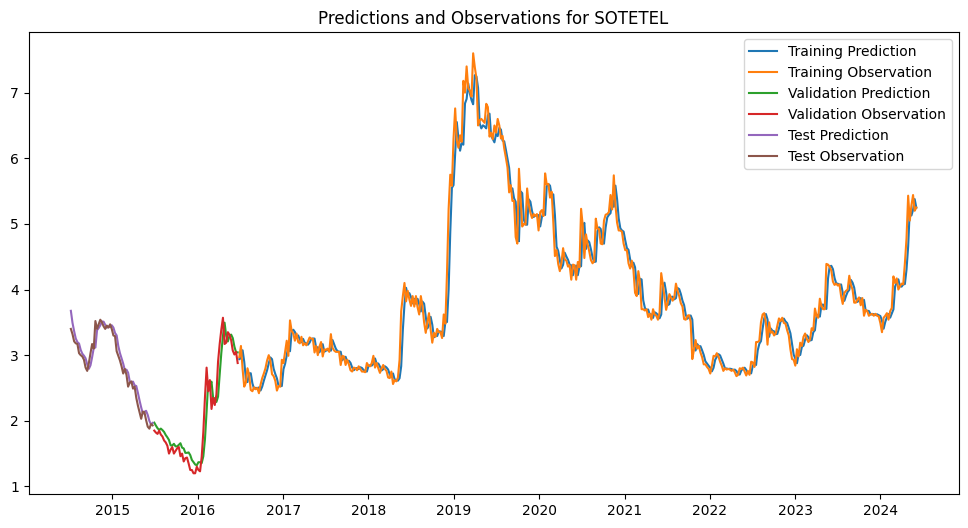

Starting recursive predictions...
1/1 [==============================] - 0s 11ms/step


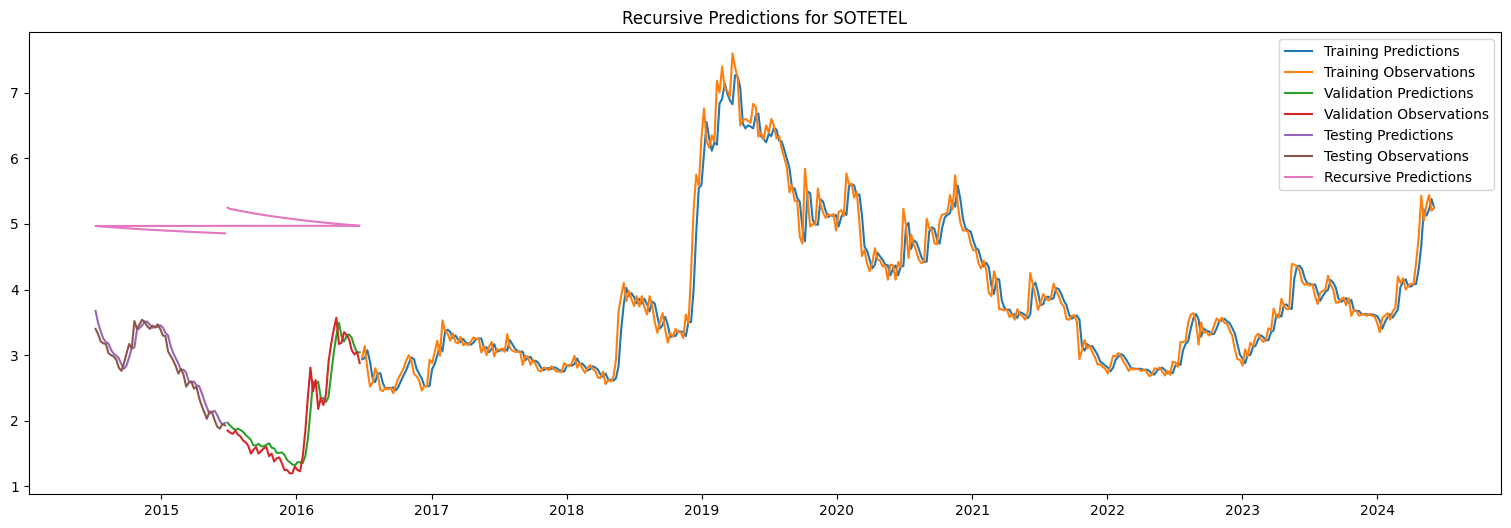

Training and plotting for SOTUVER
Starting process for SOTUVER...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


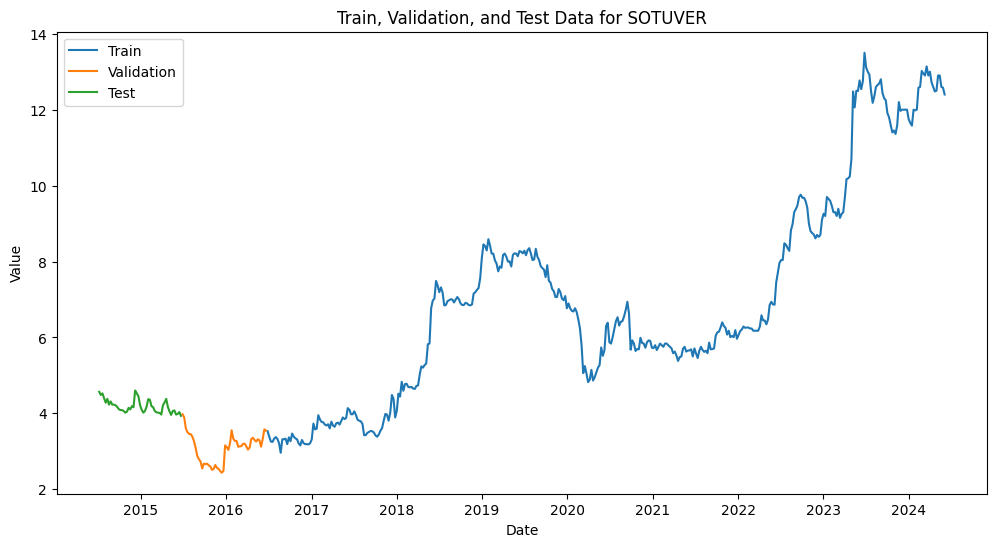

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 54.7429 - mean_absolute_error: 6.8805 - val_loss: 8.3347 - val_mean_absolute_error: 2.8642
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 48.0208 - mean_absolute_error: 6.4005 - val_loss: 6.0212 - val_mean_absolute_error: 2.4318
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 36.3169 - mean_absolute_error: 5.4483 - val_loss: 2.0322 - val_mean_absolute_error: 1.4010
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 17.6665 - mean_absolute_error: 3.4061 - val_loss: 0.9705 - val_mean_absolute_error: 0.9638
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 5.7588 - mean_absolute_error: 1.8778 - val_loss: 9.9612 - val_mean_absolute_error: 3.1460
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 4.9096 - mean_absolute_error: 1.9015 - val_loss: 3.4611 - val_mean_absolute_error: 1.8445
Epoch 7/100
13/13

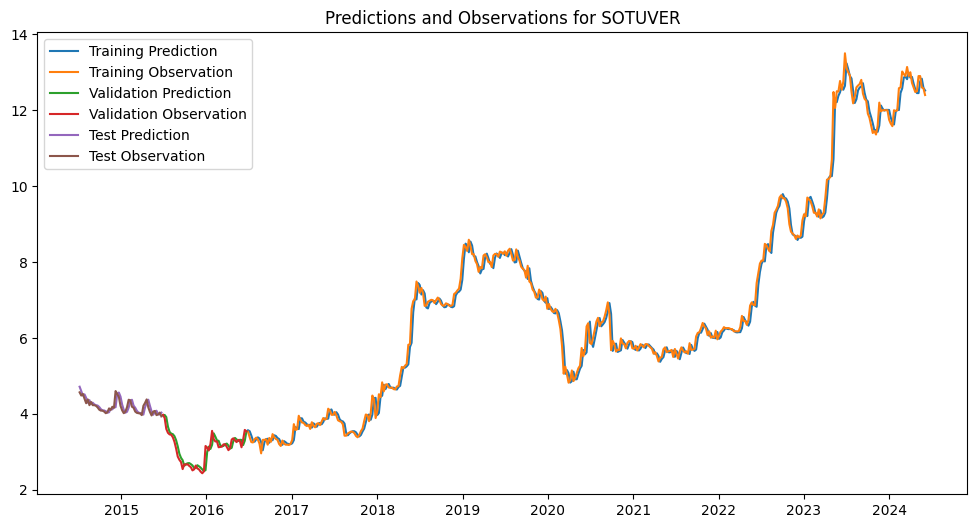

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


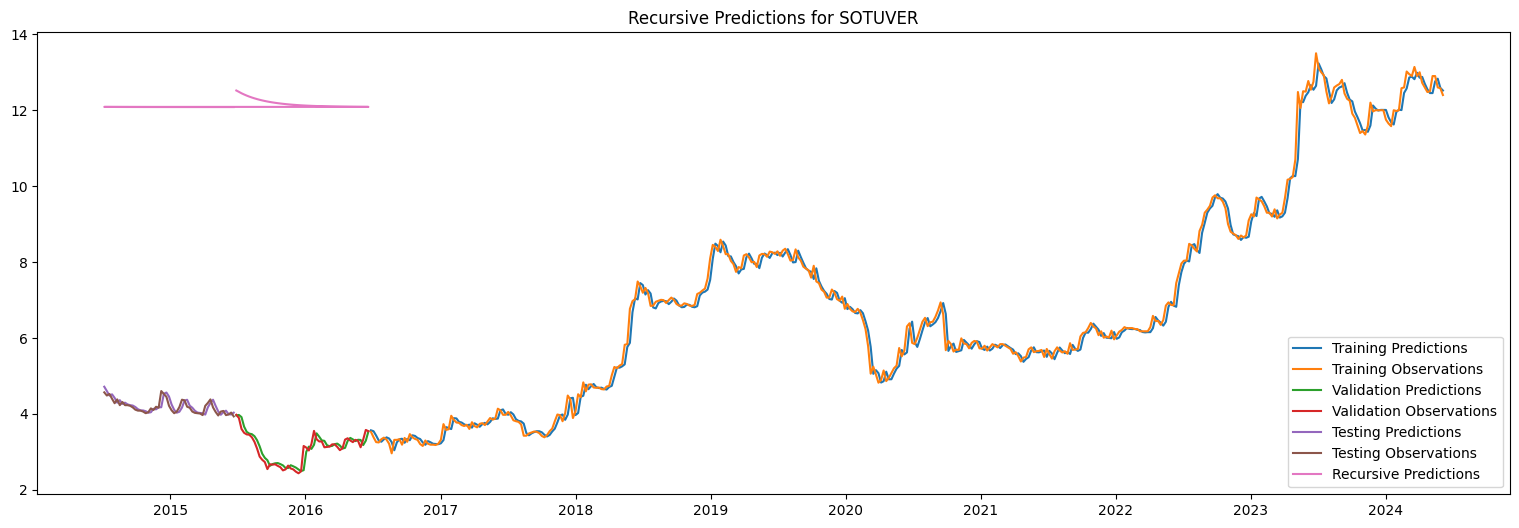

Training and plotting for TUNISAIR
Starting process for TUNISAIR...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


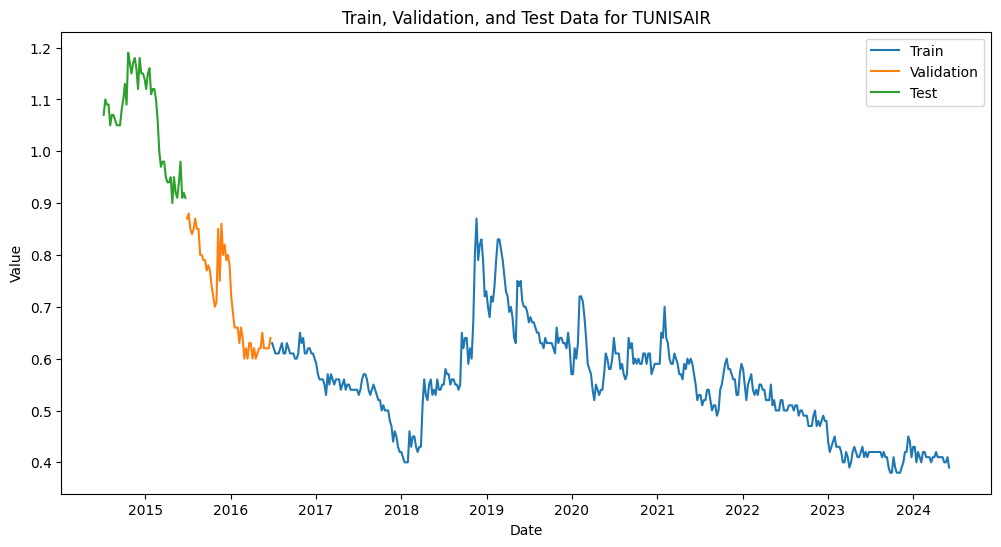

Epoch 1/100
13/13 [==============================] - 1s 17ms/step - loss: 0.2170 - mean_absolute_error: 0.4531 - val_loss: 0.2216 - val_mean_absolute_error: 0.4648
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0489 - mean_absolute_error: 0.1903 - val_loss: 0.0068 - val_mean_absolute_error: 0.0675
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0840 - val_loss: 0.0019 - val_mean_absolute_error: 0.0353
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0468 - val_loss: 0.0158 - val_mean_absolute_error: 0.1150
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0420 - val_loss: 0.0049 - val_mean_absolute_error: 0.0539
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0390 - val_loss: 0.0057 - val_mean_absolute_error: 0.0601
Epoch 7/100
13/13 [==

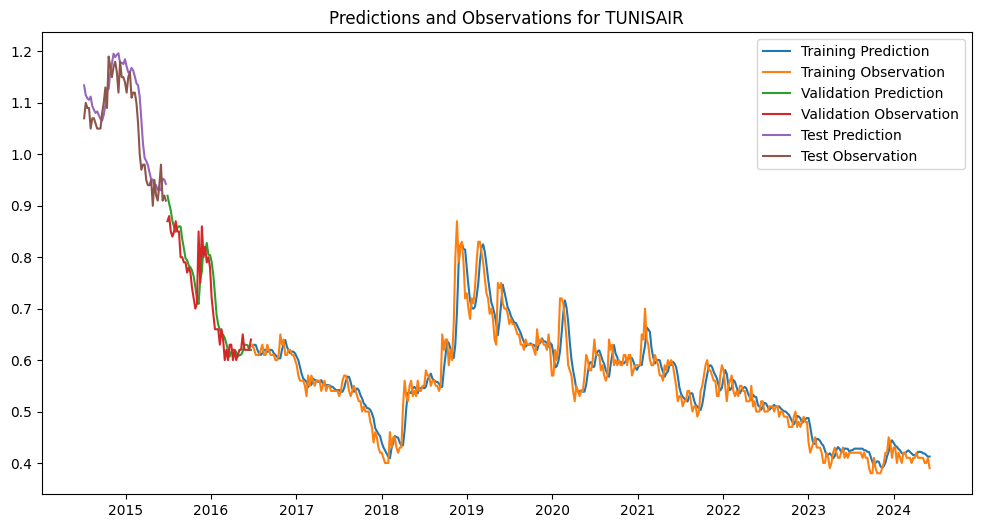

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


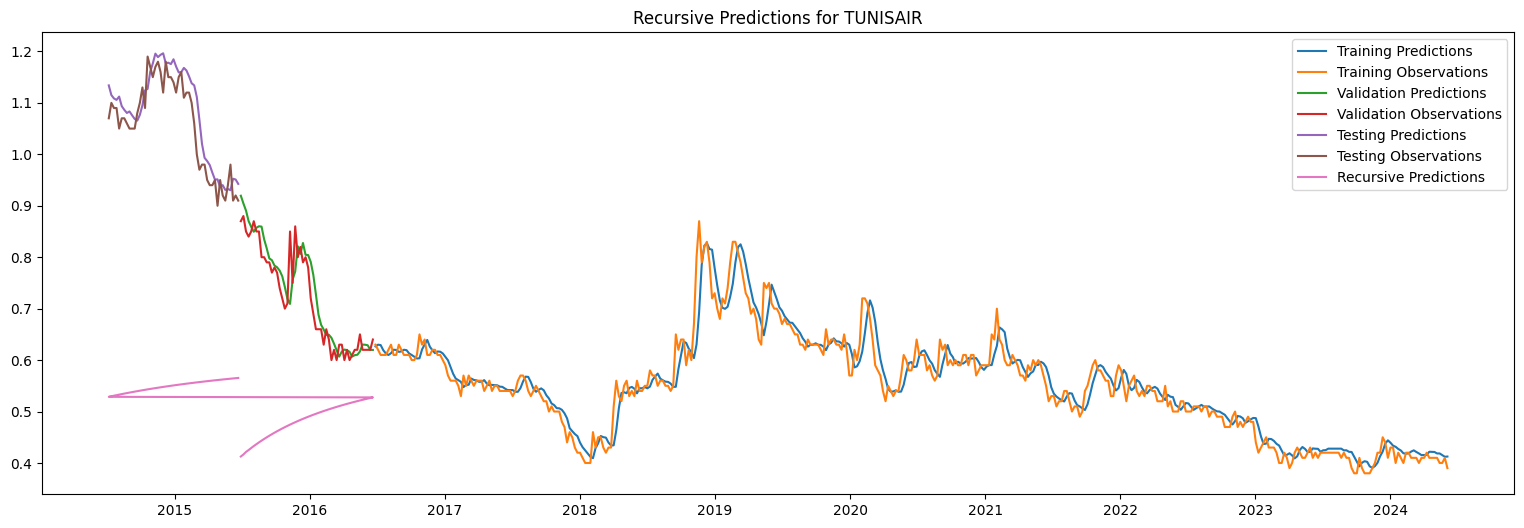

Training and plotting for BANQUE ATTIJARI DE TUNIS
Starting process for BANQUE ATTIJARI DE TUNIS...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


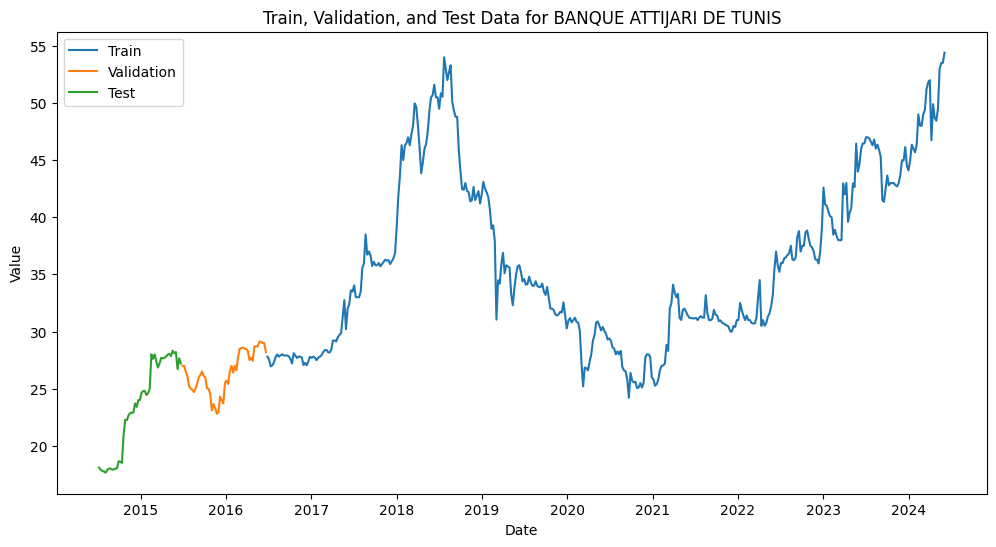

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 1319.8812 - mean_absolute_error: 35.5412 - val_loss: 644.1495 - val_mean_absolute_error: 25.3136
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 1227.6840 - mean_absolute_error: 34.2141 - val_loss: 548.6094 - val_mean_absolute_error: 23.3496
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 1064.6957 - mean_absolute_error: 31.7055 - val_loss: 390.7072 - val_mean_absolute_error: 19.6744
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 796.5326 - mean_absolute_error: 26.9977 - val_loss: 161.3318 - val_mean_absolute_error: 12.5539
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 406.2034 - mean_absolute_error: 18.2296 - val_loss: 8.3179 - val_mean_absolute_error: 2.4363
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 117.7542 - mean_absolute_error: 8.3672 - val_loss: 84.3997 - val_mean_absolute_er

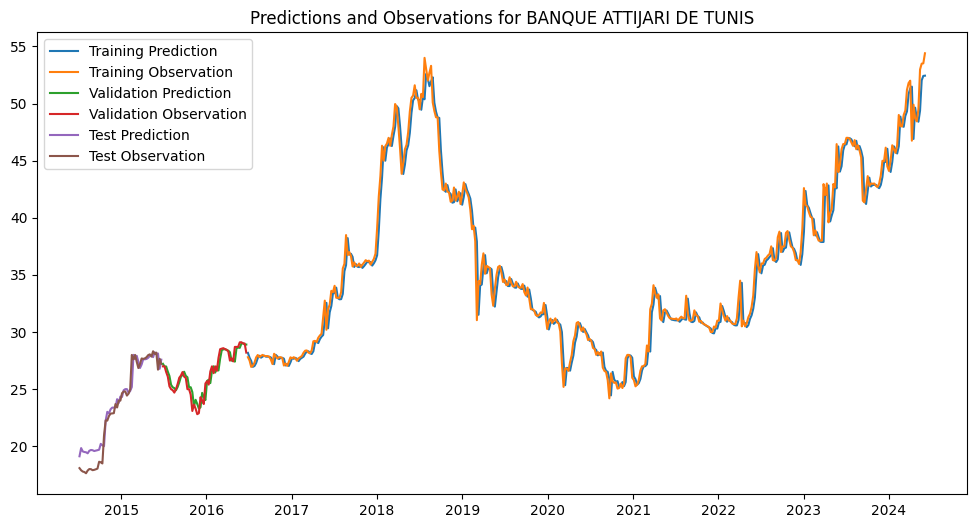

Starting recursive predictions...
1/1 [==============================] - 0s 11ms/step


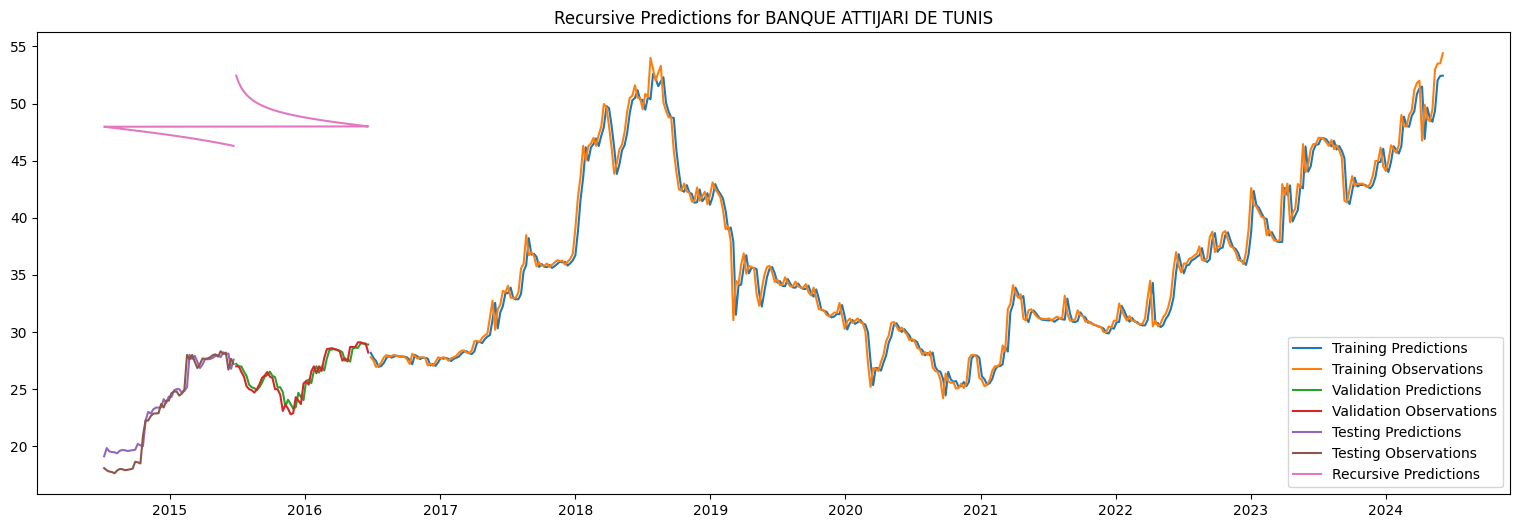

Training and plotting for TELNET HOLDING
Starting process for TELNET HOLDING...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


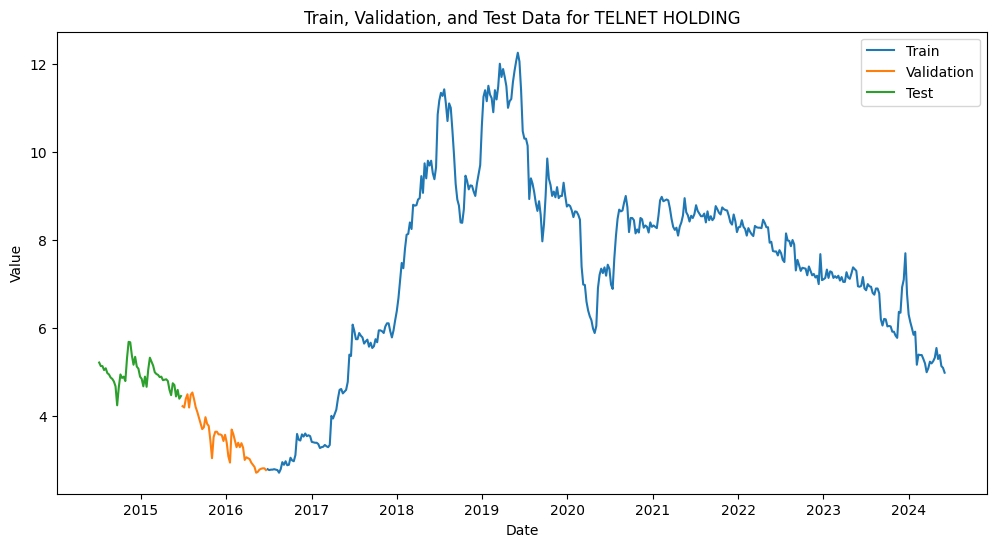

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 53.8631 - mean_absolute_error: 7.0417 - val_loss: 8.8617 - val_mean_absolute_error: 2.9388
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 41.1173 - mean_absolute_error: 6.0996 - val_loss: 4.0427 - val_mean_absolute_error: 1.9721
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 21.7751 - mean_absolute_error: 4.2574 - val_loss: 0.0757 - val_mean_absolute_error: 0.2242
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 4.9648 - mean_absolute_error: 1.7616 - val_loss: 7.0913 - val_mean_absolute_error: 2.6527
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 2.6806 - mean_absolute_error: 1.3497 - val_loss: 6.6696 - val_mean_absolute_error: 2.5711
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 1.8459 - mean_absolute_error: 1.0769 - val_loss: 2.6546 - val_mean_absolute_error: 1.6128
Epoch 7/100
13/13 

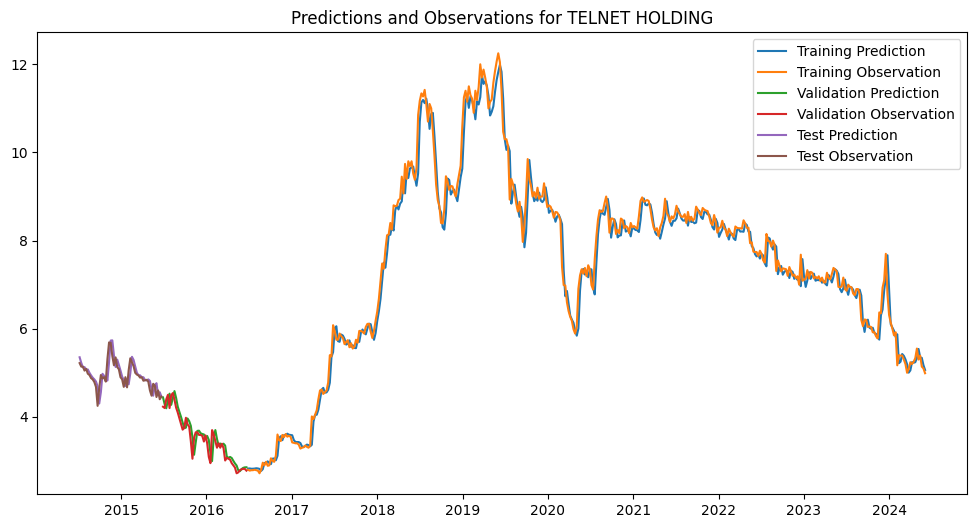

Starting recursive predictions...
1/1 [==============================] - 0s 9ms/step


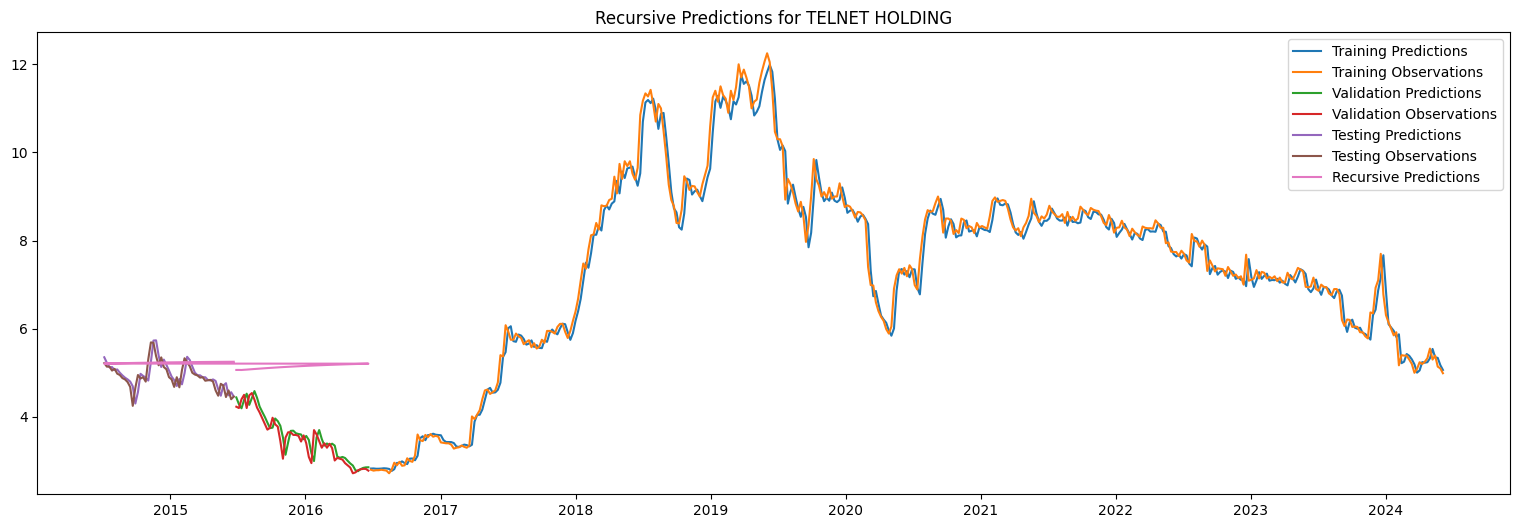

Training and plotting for TPR
Starting process for TPR...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


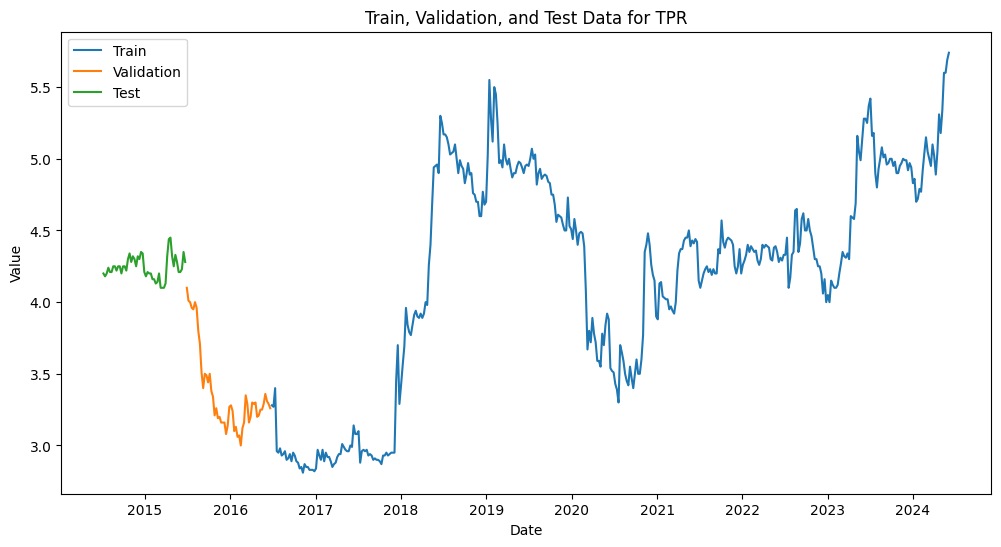

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 17.0872 - mean_absolute_error: 4.0659 - val_loss: 9.4969 - val_mean_absolute_error: 3.0700
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 13.1063 - mean_absolute_error: 3.5516 - val_loss: 5.7290 - val_mean_absolute_error: 2.3828
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 6.0326 - mean_absolute_error: 2.3443 - val_loss: 0.5852 - val_mean_absolute_error: 0.7507
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.5934 - mean_absolute_error: 0.6341 - val_loss: 1.2959 - val_mean_absolute_error: 1.1335
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.3977 - mean_absolute_error: 0.5318 - val_loss: 0.1487 - val_mean_absolute_error: 0.3674
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1888 - mean_absolute_error: 0.3667 - val_loss: 0.0835 - val_mean_absolute_error: 0.2646
Epoch 7/100
13/13 [

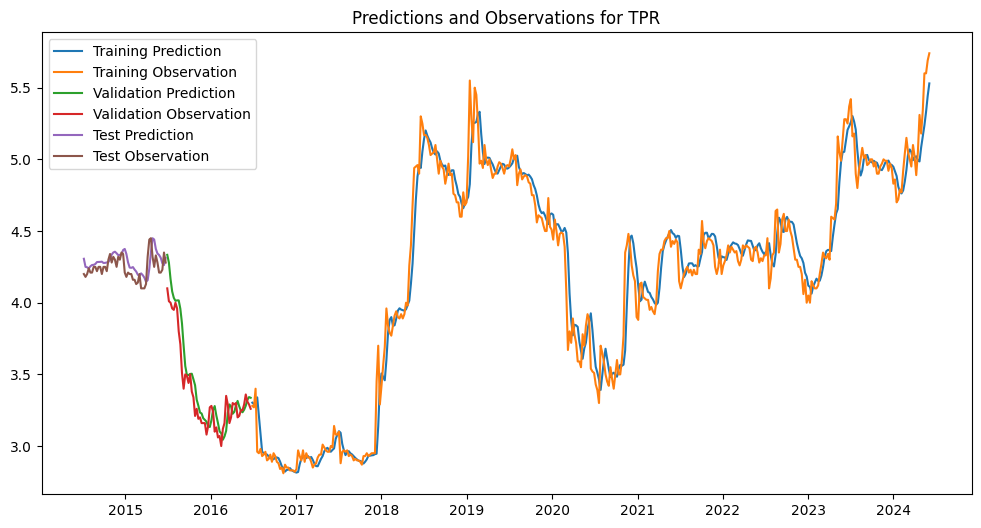

Starting recursive predictions...
1/1 [==============================] - 0s 10ms/step


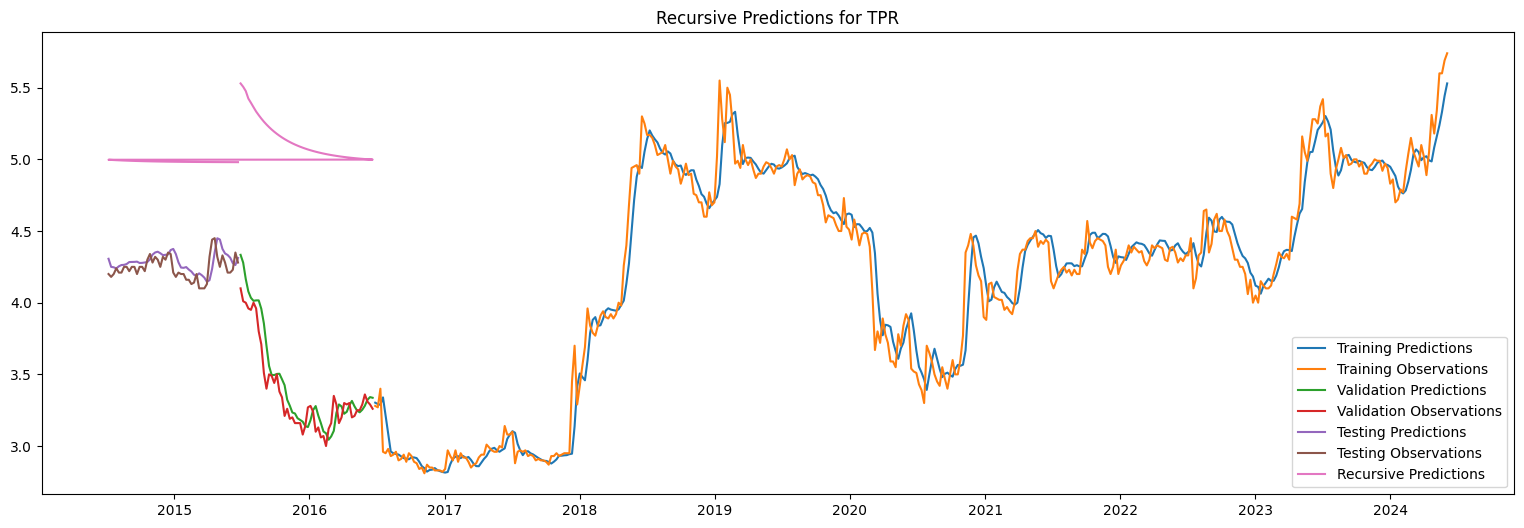

Training and plotting for UIB
Starting process for UIB...
Splitting data into train, validation, and test sets...


/var/folders/f8/cxgw8w153z5gp6y_2h70nlsh0000gn/T/ipykernel_4968/2557440718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


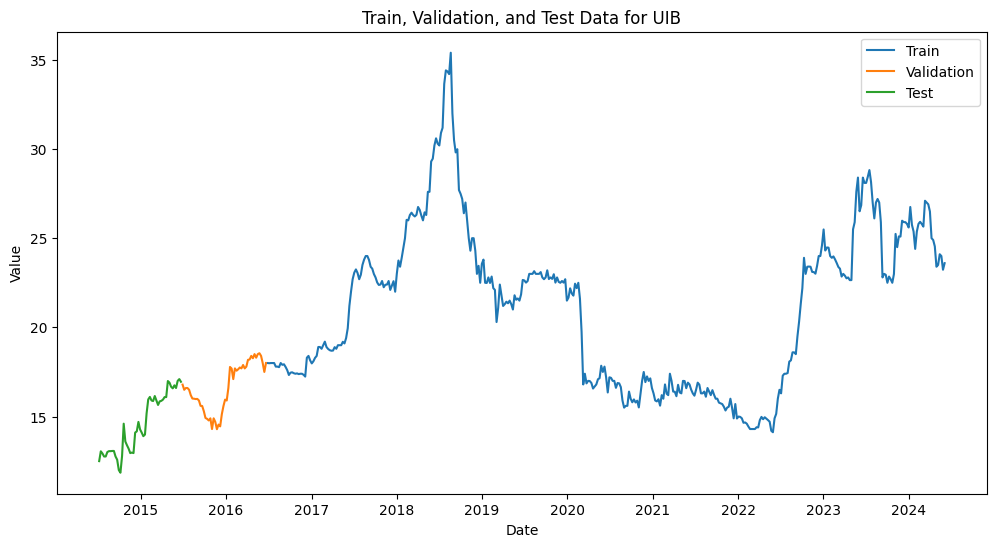

Epoch 1/100
13/13 [==============================] - 1s 18ms/step - loss: 466.9142 - mean_absolute_error: 21.1443 - val_loss: 264.9805 - val_mean_absolute_error: 16.2224
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 436.9167 - mean_absolute_error: 20.4244 - val_loss: 242.4658 - val_mean_absolute_error: 15.5126
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 400.7880 - mean_absolute_error: 19.5057 - val_loss: 204.4380 - val_mean_absolute_error: 14.2339
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 339.5699 - mean_absolute_error: 17.8536 - val_loss: 143.6923 - val_mean_absolute_error: 11.9095
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 242.6839 - mean_absolute_error: 14.8163 - val_loss: 65.0982 - val_mean_absolute_error: 7.9527
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 128.1180 - mean_absolute_error: 10.2301 - val_loss: 9.4104 - val_mean_absolute_erro

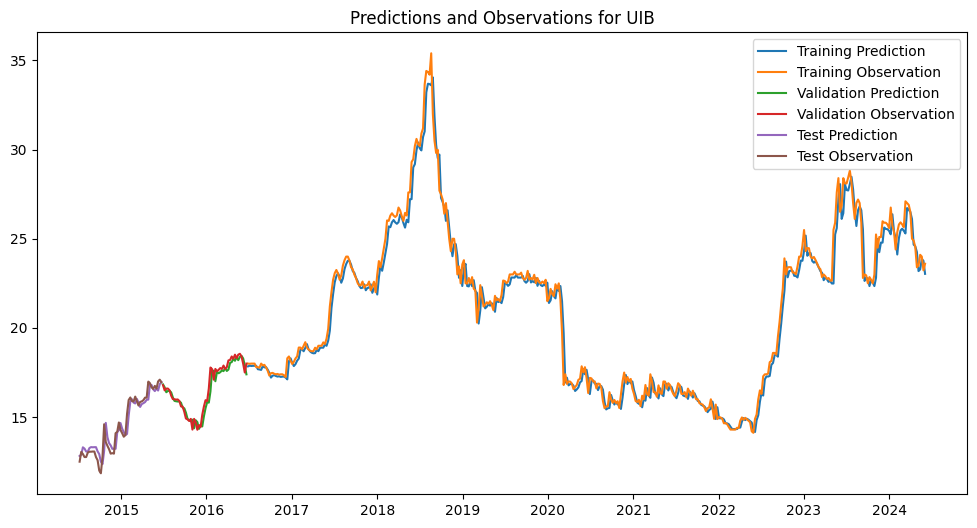

Starting recursive predictions...
1/1 [==============================] - 0s 9ms/step


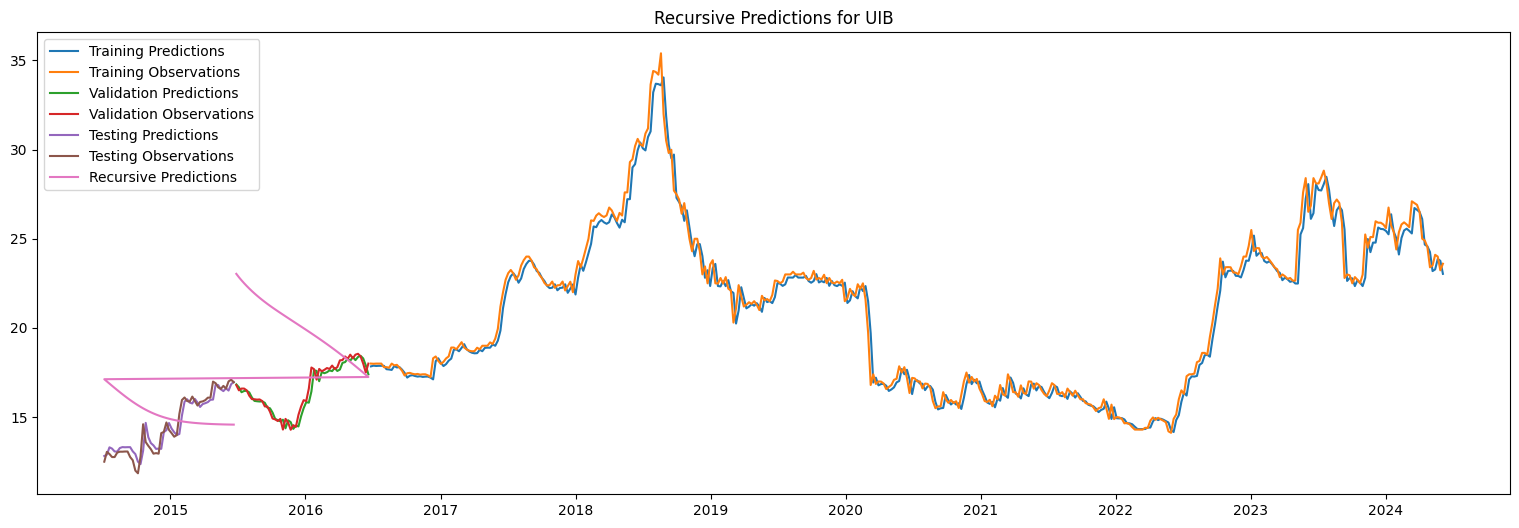

In [79]:

# Apply the model for each company
for company in companies:
    company_data = data_filtered[data_filtered['companyName'] == company]
    if not company_data.empty:
        print(f'Training and plotting for {company}')
        train_and_plot_model(company_data, company)
    else:
        print(f'No data available for {company}')
